# Analisis Perbandingan Metode Data Mining untuk Memprediksi Prestasi Akademik Mahasiswa

## Pemahaman Dataset dan Tujuan Penelitian

### Deskripsi Dataset

Penelitian ini menggunakan Student Performance Dataset yang bersumber dari dataset [Kaggle bernama Student Performance Dataset](https://www.kaggle.com/datasets/waqi786/student-performance-dataset). Dataset ini terdiri dari `5.000 baris` data dan `21 kolom`, yang mencakup informasi komprehensif tentang performa akademik, kebiasaan belajar, faktor psikologis, dan latar belakang sosial-ekonomi mahasiswa. Kolom-kolom dalam dataset meliputi:

`Variabel Akademik`: Attendance (%), Midterm_Score, Final_Score, Assignments_Avg, Quizzes_Avg, Participation_Score, Projects_Score, dan Total_Score (variabel target).

`Variabel Perilaku`: Study_Hours_per_Week, Sleep_Hours_per_Night, dan Extracurricular_Activities (Yes/No).

`Variabel Psikologis`: Stress_Level (skala 1-10).

`Variabel Demografis dan Sosial-Ekonomi`: Student_ID, First_Name, Last_Name, Email, Gender, Age, Department, Parent_Education_Level, Family_Income_Level, dan Internet_Access_at_Home.

`Variabel Hasil`: Grade (kategorikal, A/B/C/D/F), yang merupakan turunan dari Total_Score dan tidak digunakan sebagai fitur dalam prediksi.

`Total_Score` adalah variabel kontinu yang merepresentasikan jumlah tertimbang dari semua nilai akademik mahasiswa, mencerminkan performa akademik secara keseluruhan. Dataset ini kaya akan fitur numerik dan kategorikal, sehingga cocok untuk analisis prediktif menggunakan pendekatan regresi.

### Tujuan Penelitian

Penelitian ini bertujuan untuk memprediksi `Total_Score` mahasiswa menggunakan lima metode regresi berbasis data mining, yaitu `Linear Regression`, `Ridge Regression`, `Random Forest Regressor`, `Gradient Boosting Regressor (XGBoost)`, dan `Support Vector Regression (SVR)`. Tujuan spesifik meliputi:

- Mengembangkan model prediktif untuk memperkirakan Total_Score berdasarkan fitur akademik, perilaku, psikologis, dan sosial-ekonomi.
- Membandingkan performa kelima metode regresi berdasarkan metrik evaluasi seperti Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), dan R² Score untuk menentukan model yang paling akurat dan efisien.
- Mengidentifikasi fitur utama yang paling memengaruhi Total_Score, seperti kehadiran (Attendance), nilai ujian tengah semester (Midterm_Score), atau jam belajar per minggu (Study_Hours_per_Week), untuk memberikan wawasan bagi institusi pendidikan dalam mendukung performa mahasiswa.

### Konteks dan Relevansi

Prediksi performa akademik mahasiswa memiliki nilai praktis yang tinggi, terutama untuk institusi pendidikan dalam mengidentifikasi faktor-faktor yang memengaruhi keberhasilan akademik dan merancang intervensi yang tepat, seperti program bimbingan atau dukungan belajar. Dengan membandingkan berbagai metode regresi, penelitian ini juga bertujuan untuk memberikan rekomendasi model terbaik yang dapat diimplementasikan dalam skenario dunia nyata, sekaligus memahami kelebihan dan keterbatasan masing-masing metode dalam konteks dataset ini.

Import library & Dataset

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import chrono
import os
from math import ceil

In [175]:
# Mengatur gaya visualisasi
sns.set(style="whitegrid")

# Fungsi untuk mengonversi nilai boolean dengan aman
def parse_boolean(nilai):
    if isinstance(nilai, str):
        nilai = nilai.strip().lower()
        if nilai in ['ya', 'yes', 'true', 'on']:
            return True
        if nilai in ['tidak', 'no', 'false', 'off']:
            return False
    return nilai

In [176]:
# Fungsi untuk memparsing tanggal dengan aman menggunakan chrono
def parse_date(nilai):
    if isinstance(nilai, str):
        tanggal = chrono.parseDate(nilai)
        return tanggal if tanggal else nilai
    return nilai

In [177]:
# Memuat dan membersihkan dataset
def muat_dan_bersihkan_data(file_path):
    try:
        # Membaca file CSV
        df = pd.read_csv(file_path, dtype_backend='numpy_nullable')
        
        # Membersihkan header dan nilai
        df.columns = [col.strip().replace('"', '') for col in df.columns]
        df = df.apply(lambda x: x.str.strip().str.replace('"', '') if x.dtype == "string" else x)    
        
        # Mengonversi tipe data berdasarkan metadata
        peta_tipe = {
            'Student_ID': str,
            'First_Name': str,
            'Last_Name': str,
            'Email': str,
            'Gender': 'category',
            'Age': 'Int32',
            'Department': 'category',
            'Attendance (%)': float,
            'Midterm_Score': float,
            'Final_Score': float,
            'Assignments_Avg': float,
            'Quizzes_Avg': float,
            'Participation_Score': float,
            'Projects_Score': float,
            'Total_Score': float,
            'Grade': 'category',
            'Study_Hours_per_Week': float,
            'Extracurricular_Activities': bool,
            'Internet_Access_at_Home': bool,
            'Parent_Education_Level': 'category',
            'Family_Income_Level': 'category',
            'Stress_Level (1-10)': 'Int32',
            'Sleep_Hours_per_Night': float
        }
        
        # Menerapkan konversi tipe
        for kol, tipe in peta_tipe.items():
            if kol in df.columns:
                if tipe == bool:
                    df[kol] = df[kol].apply(parse_boolean).astype(bool)
                elif tipe == 'Int32':
                    df[kol] = pd.to_numeric(df[kol], errors='coerce').astype('Int32')
                else:
                    df[kol] = df[kol].astype(tipe)
        
        return df
    except Exception as e:
        print(f"Error saat memuat data: {e}")
        return None

In [178]:
# Mendeskripsikan dataset
def deskripsikan_dataset(df):
    deskripsi = {
        'Statistik Ringkas (Numerik)': df.select_dtypes(include=['int32', 'float64']).describe(),
        'Statistik Ringkas (Kategorikal)': df.select_dtypes(include=['category']).describe(),
        'Nilai Hilang': df.isnull().sum(),
        'Tipe Data': df.dtypes
    }
    return deskripsi

In [179]:
# Memvisualisasikan dataset dengan canvas terpisah dan maksimal 2 kolom per canvas
def visualisasikan_dataset(df, direktori_keluaran='plot'):
    if not os.path.exists(direktori_keluaran):
        os.makedirs(direktori_keluaran)
    
    # Daftar kolom untuk visualisasi
    kolom_numerik = ['Age', 'Attendance (%)', 'Midterm_Score', 'Final_Score', 
                     'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score', 
                     'Projects_Score', 'Total_Score', 'Study_Hours_per_Week', 
                     'Sleep_Hours_per_Night', 'Stress_Level (1-10)']
    kolom_kategorikal = ['Gender', 'Department', 'Grade', 'Parent_Education_Level', 'Family_Income_Level']
    kolom_boolean = ['Extracurricular_Activities', 'Internet_Access_at_Home']
    
    # Histogram untuk kolom numerik dalam satu canvas
    kolom_numerik_ada = [kol for kol in kolom_numerik if kol in df.columns]
    if kolom_numerik_ada:
        n_cols = min(2, len(kolom_numerik_ada))
        n_rows = ceil(len(kolom_numerik_ada) / 2)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
        axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
        for i, kol in enumerate(kolom_numerik_ada):
            sns.histplot(df[kol].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'Distribusi {kol}')
            axes[i].set_xlabel(kol)
            axes[i].set_ylabel('Frekuensi')
        # Menonaktifkan subplot kosong
        for i in range(len(kolom_numerik_ada), len(axes)):
            axes[i].axis('off')
        plt.savefig(f'{direktori_keluaran}/histogram_numerik.png')
        plt.show()
    
    # Boxplot untuk kolom numerik dalam satu canvas
    if kolom_numerik_ada:
        n_cols = min(2, len(kolom_numerik_ada))
        n_rows = ceil(len(kolom_numerik_ada) / 2)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
        axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
        for i, kol in enumerate(kolom_numerik_ada):
            sns.boxplot(y=df[kol].dropna(), ax=axes[i])
            axes[i].set_title(f'Boxplot {kol}')
            axes[i].set_ylabel(kol)
        for i in range(len(kolom_numerik_ada), len(axes)):
            axes[i].axis('off')
        plt.savefig(f'{direktori_keluaran}/boxplot_numerik.png')
        plt.show()
    
    # Diagram batang untuk kolom kategorikal dalam satu canvas
    kolom_kategorikal_ada = [kol for kol in kolom_kategorikal if kol in df.columns]
    if kolom_kategorikal_ada:
        n_cols = min(2, len(kolom_kategorikal_ada))
        n_rows = ceil(len(kolom_kategorikal_ada) / 2)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
        axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
        for i, kol in enumerate(kolom_kategorikal_ada):
            sns.countplot(x=df[kol].dropna(), ax=axes[i])
            axes[i].set_title(f'Frekuensi {kol}')
            axes[i].set_xlabel(kol)
            axes[i].set_ylabel('Jumlah')
            axes[i].tick_params(axis='x', rotation=45)
        for i in range(len(kolom_kategorikal_ada), len(axes)):
            axes[i].axis('off')
        plt.savefig(f'{direktori_keluaran}/diagram_batang_kategorikal.png')
        plt.show()
    
    # Diagram lingkaran untuk kolom boolean dalam satu canvas
    kolom_boolean_ada = [kol for kol in kolom_boolean if kol in df.columns]
    if kolom_boolean_ada:
        n_cols = min(2, len(kolom_boolean_ada))
        n_rows = ceil(len(kolom_boolean_ada) / 2)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
        axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
        for i, kol in enumerate(kolom_boolean_ada):
            df[kol].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[i])
            axes[i].set_title(f'Proporsi {kol}')
            axes[i].set_ylabel('')
        for i in range(len(kolom_boolean_ada), len(axes)):
            axes[i].axis('off')
        plt.savefig(f'{direktori_keluaran}/diagram_lingkaran_boolean.png')
        plt.show()
    
    # Heatmap korelasi dalam satu canvas
    if len(kolom_numerik_ada) > 1:
        fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)
        korelasi = df[kolom_numerik_ada].corr()
        sns.heatmap(korelasi, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
        ax.set_title('Heatmap Korelasi Fitur Numerik')
        plt.savefig(f'{direktori_keluaran}/heatmap_korelasi.png')
        plt.show()
    
    # Scatter plot dalam satu canvas
    if 'Total_Score' in df.columns and 'Study_Hours_per_Week' in df.columns:
        fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
        sns.scatterplot(x='Study_Hours_per_Week', y='Total_Score', data=df, ax=ax)
        ax.set_title('Total Skor vs Jam Belajar per Minggu')
        ax.set_xlabel('Jam Belajar per Minggu')
        ax.set_ylabel('Total Skor')
        plt.savefig(f'{direktori_keluaran}/scatter_total_skor_jam_belajar.png')
        plt.show()

Deskripsi Dataset:

Ringkasan Numerik:
            Age  Attendance (%)  Midterm_Score  Final_Score  Assignments_Avg  \
count    5000.0     5000.000000    5000.000000  5000.000000      5000.000000   
mean    21.0484       75.356076      70.701924    69.546552        74.956320   
std    1.989786       14.392716      17.436325    17.108996        14.404287   
min        18.0       50.010000      40.000000    40.010000        50.000000   
25%        19.0       62.945000      55.707500    54.697500        62.340000   
50%        21.0       75.670000      70.860000    69.485000        75.090000   
75%        23.0       87.862500      85.760000    83.922500        87.352500   
max        24.0      100.000000      99.990000    99.980000        99.990000   

       Quizzes_Avg  Participation_Score  Projects_Score  Total_Score  \
count  5000.000000          5000.000000      5000.00000  5000.000000   
mean     74.836214             4.996372        74.78305    75.021860   
std      14.423848      

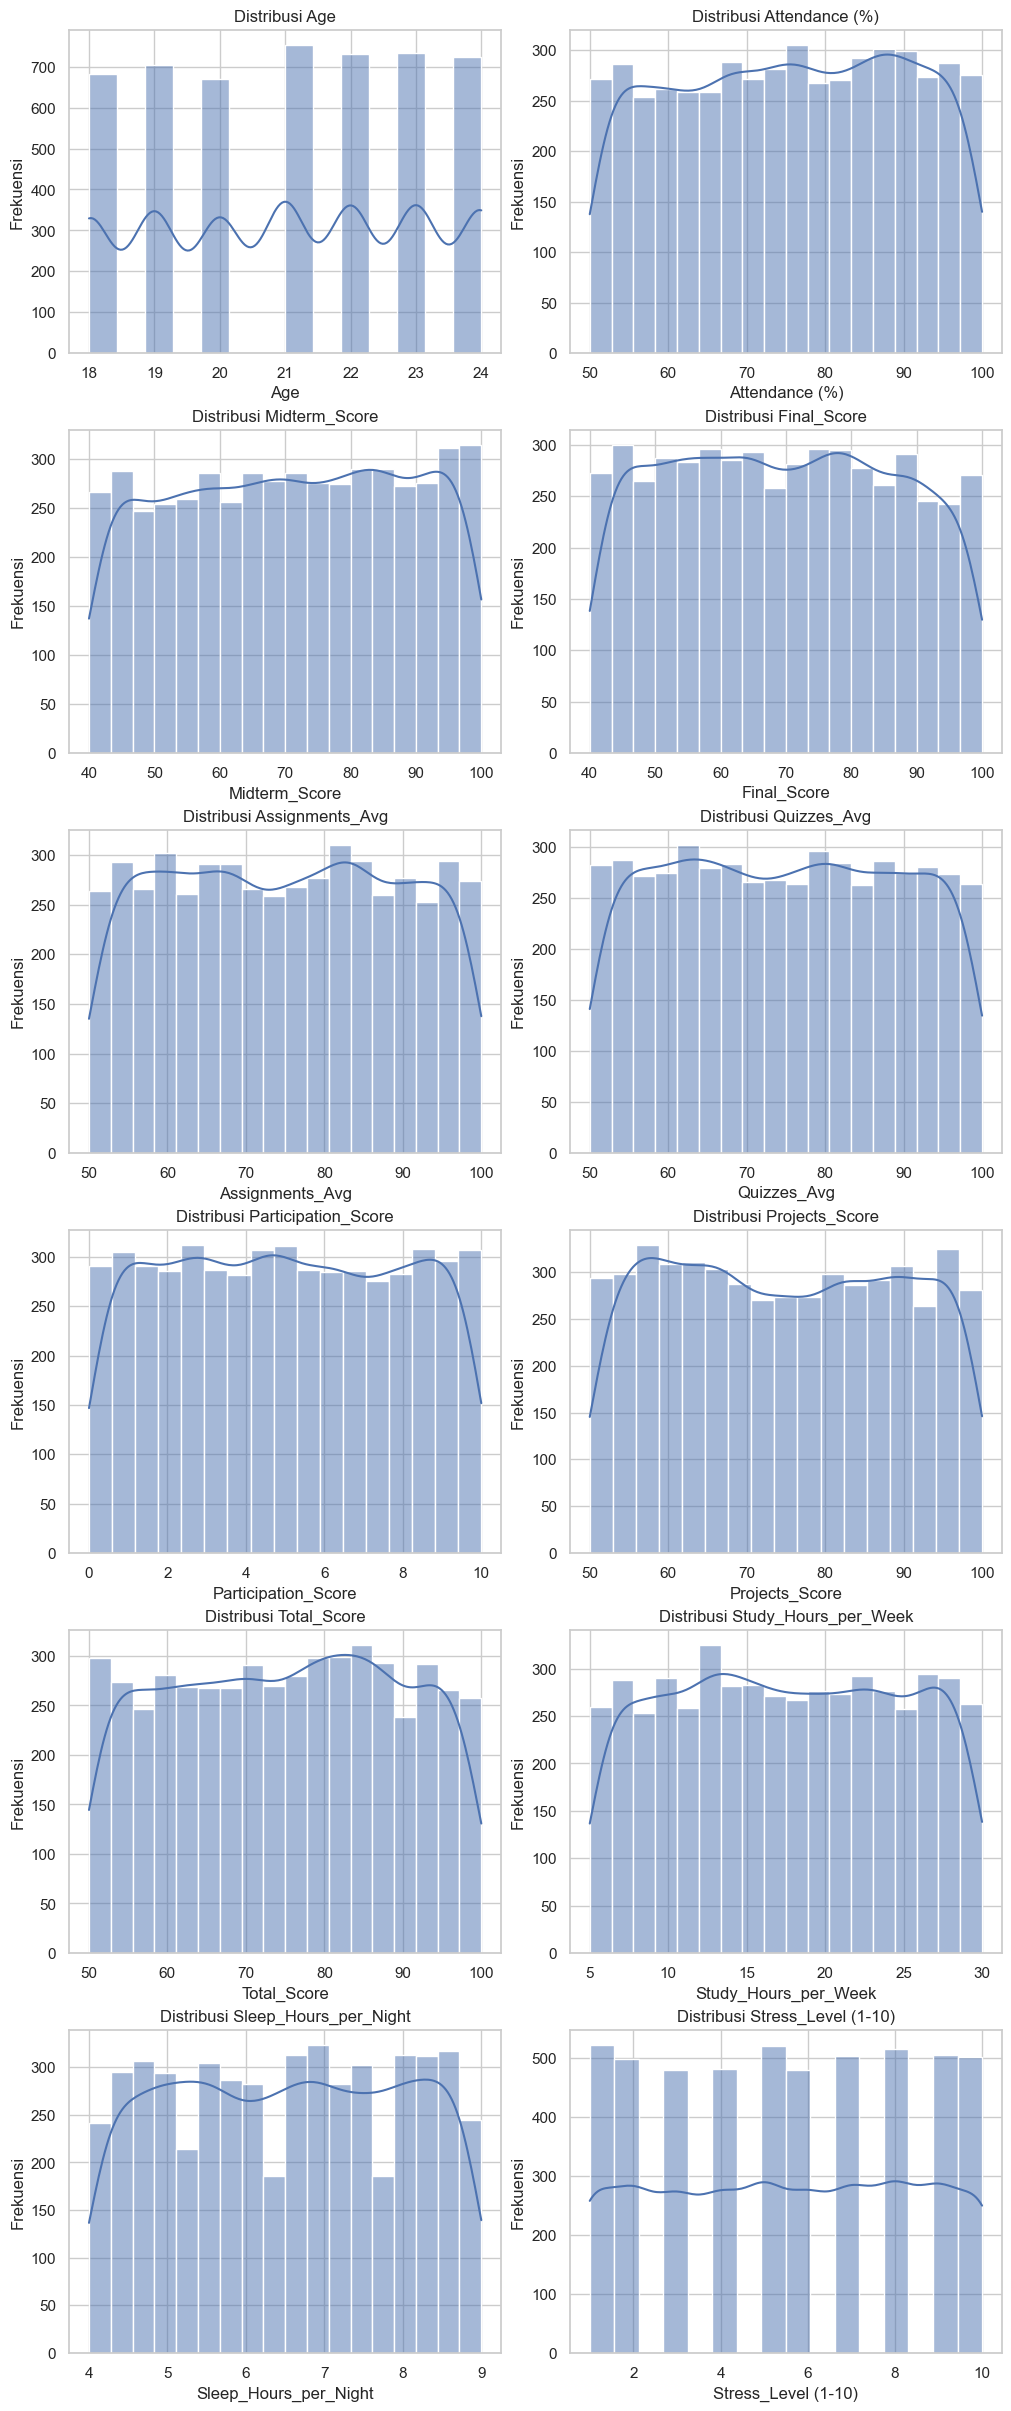

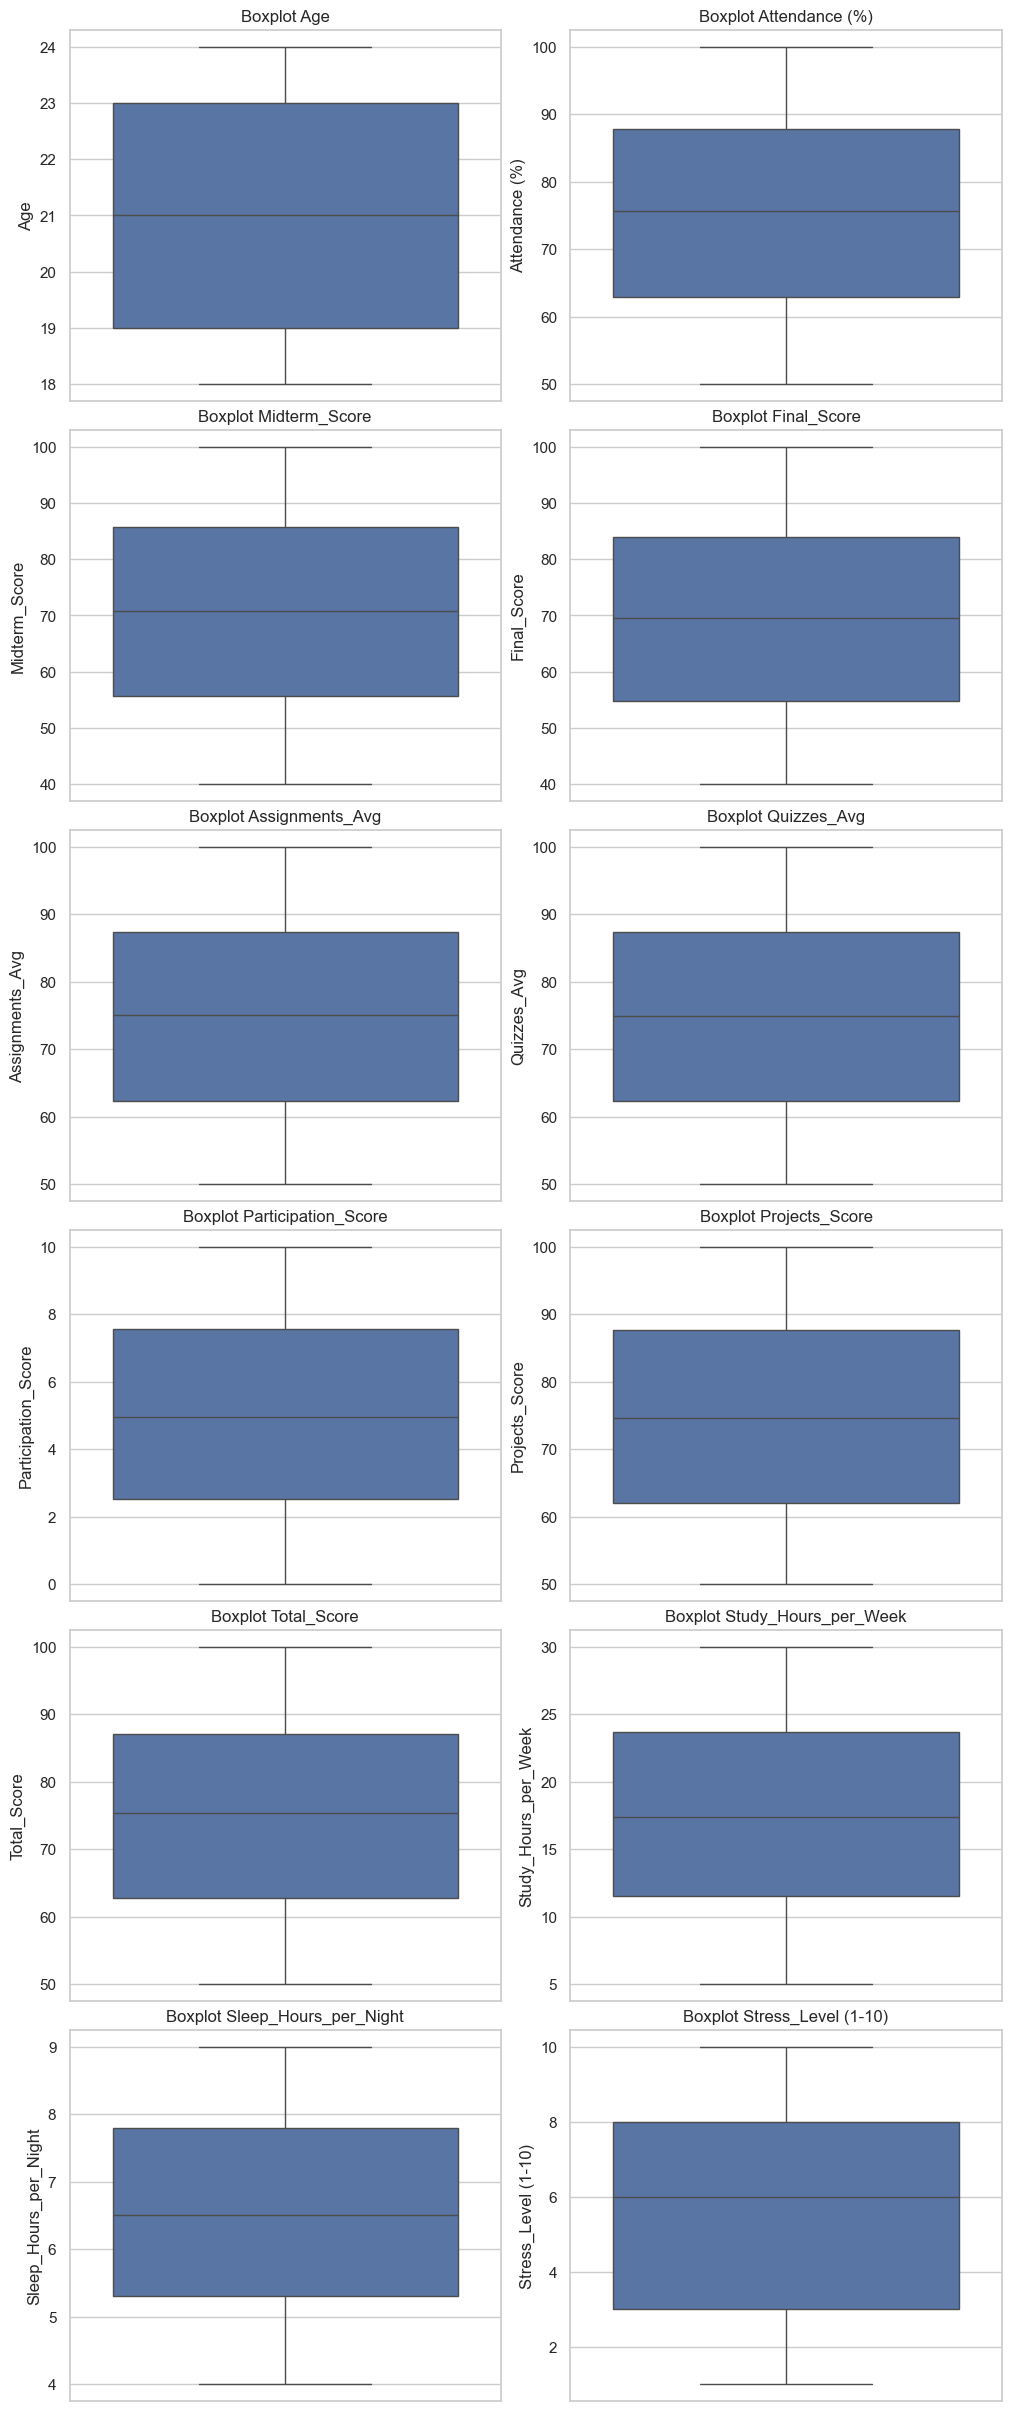

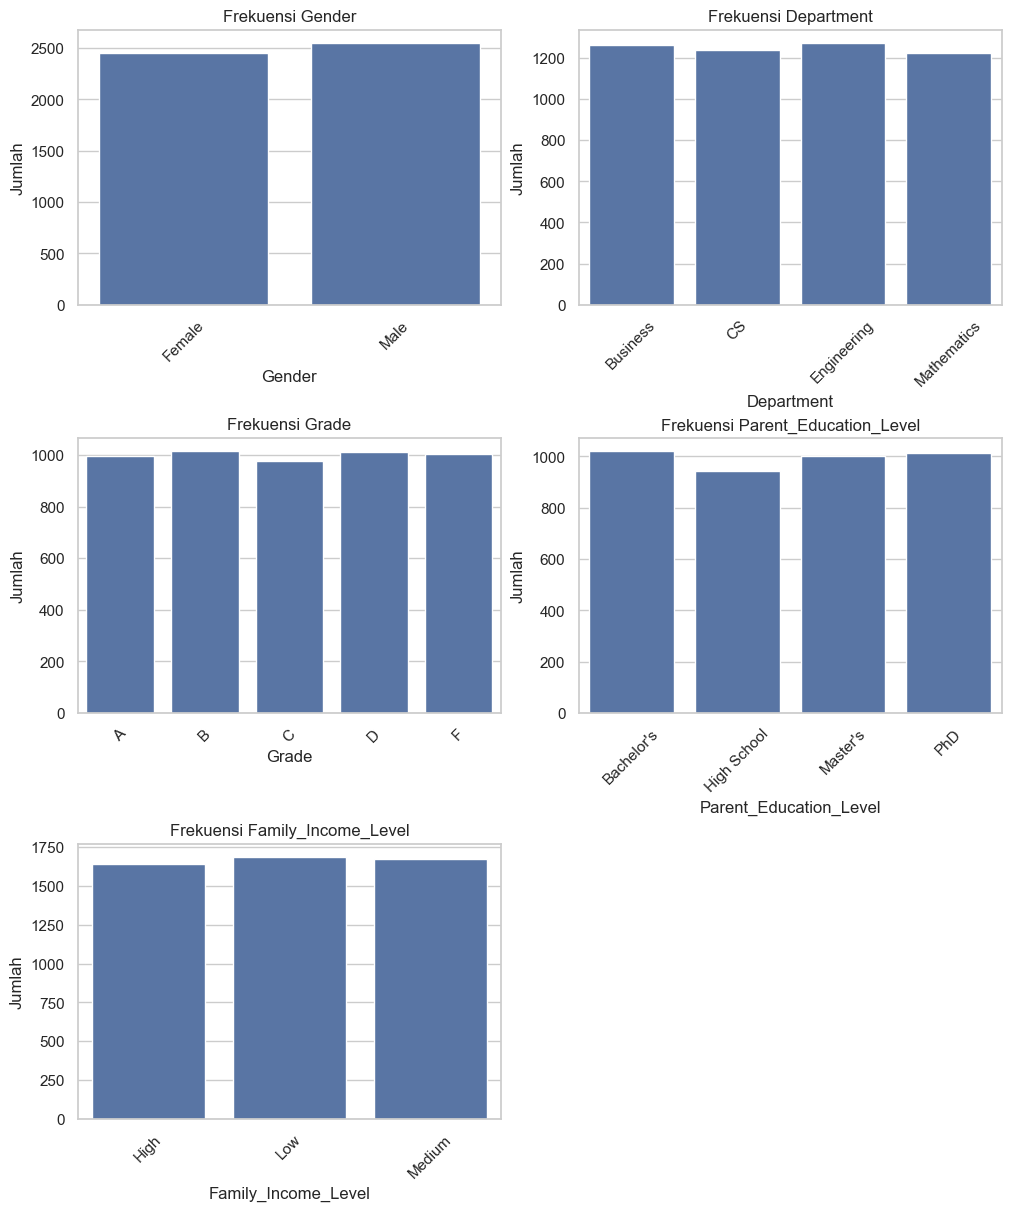

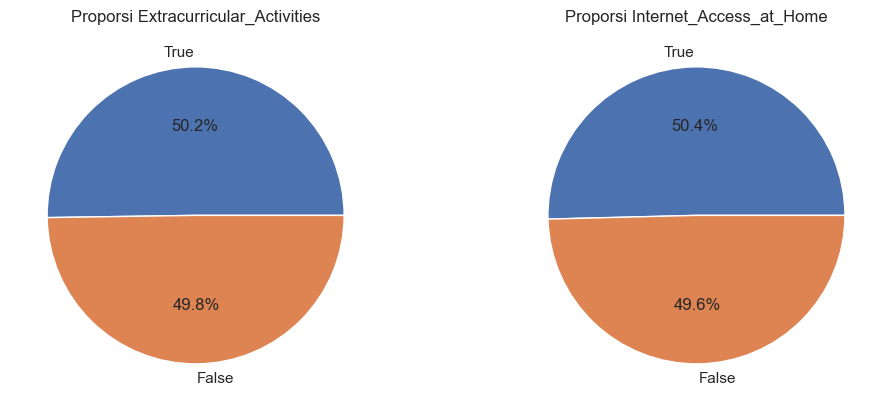

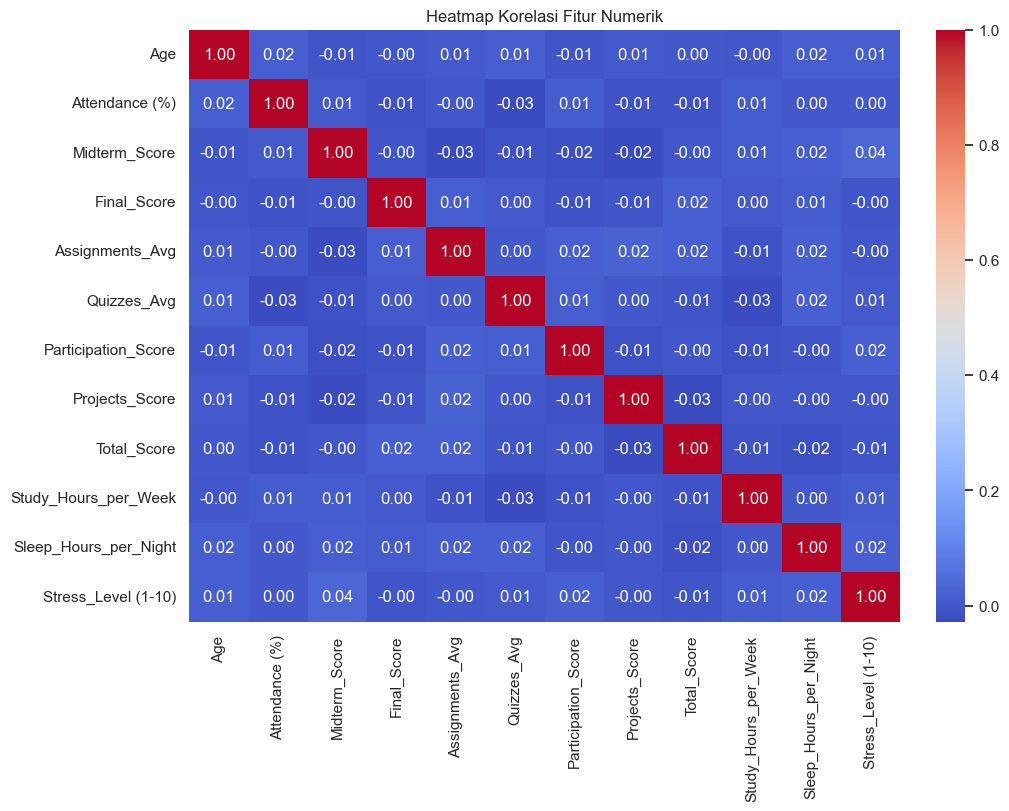

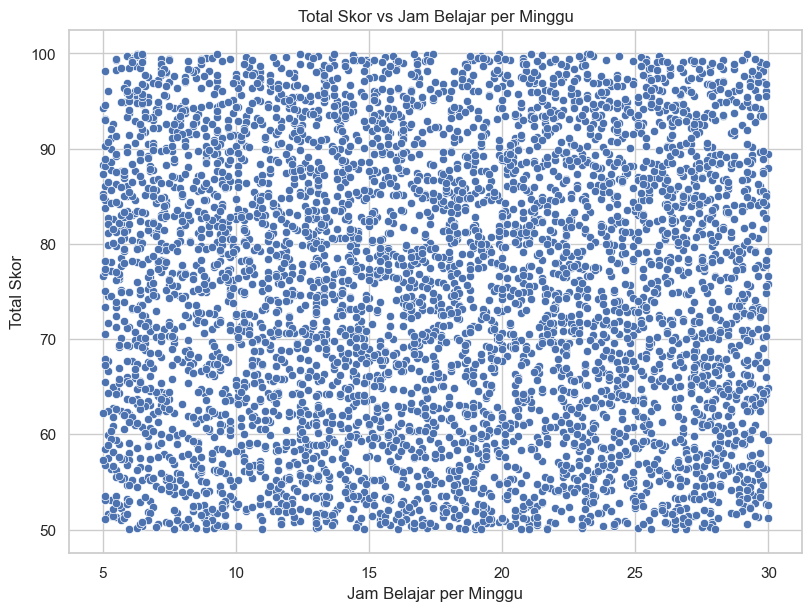

In [180]:
file_path = 'dataset/Students_Grading_Dataset.csv'

df = muat_dan_bersihkan_data(file_path)
    
if df is not None:
    # Mendeskripsikan dataset
    deskripsi = deskripsikan_dataset(df)
    print("Deskripsi Dataset:")
    print("\nRingkasan Numerik:")
    print(deskripsi['Statistik Ringkas (Numerik)'])
    print("\nRingkasan Kategorikal:")
    print(deskripsi['Statistik Ringkas (Kategorikal)'])
    print("\nNilai Hilang:")
    print(deskripsi['Nilai Hilang'])
    print("\nTipe Data:")
    print(deskripsi['Tipe Data'])
    
    # Memvisualisasikan dataset
    visualisasikan_dataset(df)

### Interpretasi Ringkasan Dataset

Berdasarkan ringkasan numerik dan kategorikal yang diberikan, berikut adalah interpretasi dari dataset yang berisi data kinerja mahasiswa:

1. Ringkasan Numerik

Dataset berisi 5.000 entri. Berikut adalah interpretasi dari ringkasan numerik dan kategorikal, serta insight spesifik terkait keputusan untuk mengganti nilai hilang dengan modus dan implikasinya untuk prediksi:

- Age (Usia):
  - Rentang: 18–24 tahun (mean: ~21.05, std: ~1.99).
  - Insight: Distribusi usia tetap konsisten dengan dataset sebelumnya (3.975 entri), dengan variasi kecil. Rentang usia ini tipikal untuk mahasiswa universitas, sehingga tidak ada anomali signifikan.

- Attendance (%) (Kehadiran):
  - Rentang: 50.01–100% (mean: ~75.36, std: ~14.39).
  - Insight: Kehadiran memiliki variasi sedang, dengan beberapa mahasiswa memiliki kehadiran rendah (~50%). Ini bisa menjadi prediktor penting untuk kinerja akademik, karena kehadiran rendah mungkin berkorelasi dengan nilai rendah.

- Midterm_Score, Final_Score, Assignments_Avg, Quizzes_Avg, Projects_Score, Total_Score:
  - Rentang: Sekitar 40–100 (kecuali Participation_Score: 0–10).
  - Mean: Berkisar antara ~69.55 (Final_Score) hingga ~75.02 (Total_Score).
  - Standar deviasi: ~14–17, menunjukkan variasi sedang dalam nilai akademik.
  - Insight: Nilai akademik cenderung terdistribusi normal dengan rata-rata di atas 70, tetapi ada mahasiswa dengan nilai rendah (min: ~40–50). Assignments_Avg memiliki rata-rata tertinggi, menunjukkan mahasiswa cenderung berkinerja baik pada tugas.

- Participation_Score:
  - Rentang: 0–10 (mean: ~5.00, std: ~2.90).
  - Insight: Nilai 0 menonjol sebagai potensi outlier, karena jauh di bawah rata-rata. Ini mungkin menunjukkan mahasiswa yang tidak berpartisipasi sama sekali, yang bisa menjadi faktor penting dalam prediksi.

- Study_Hours_per_Week (Jam Belajar per Minggu):
  - Rentang: 5–30 jam (mean: ~17.52, std: ~7.19).
  - Insight: Variasi besar dalam jam belajar menunjukkan perbedaan kebiasaan belajar. Nilai ekstrem (5 atau 30 jam) bisa memengaruhi kinerja akademik dan perlu diperiksa untuk outlier.

- Stress_Level (1-10):
  - Rentang: 1–10 (mean: ~5.51, std: ~2.89).
  - Insight: Tingkat stres terdistribusi secara merata, dengan median 6. Ini bisa menjadi prediktor penting, karena stres tinggi mungkin berkorelasi dengan kinerja akademik yang buruk.

- Sleep_Hours_per_Night (Jam Tidur per Malam):
  - Rentang: 4–9 jam (mean: ~6.51, std: ~1.45).
  - Insight: Jam tidur rata-rata cukup, tetapi nilai rendah (4 jam) mungkin menunjukkan kebiasaan tidur tidak sehat, yang bisa memengaruhi kinerja akademik.

2. Ringkasan Kategorikal
- Gender (Jenis Kelamin):
  - Kategori: Male (2.551), Female (2.449).
  - Interpretasi: Distribusi jenis kelamin hampir seimbang, dengan sedikit lebih banyak laki-laki.

- Department (Jurusan):
  - Kategori: Engineering (1.274, terbanyak), diikuti oleh jurusan lain (misalnya, Business, yang sebelumnya terbanyak di dataset 3.975 entri).
  - Interpretasi: Jurusan Engineering paling populer, yang mungkin memengaruhi analisis kinerja akademik jika jurusan memiliki kurikulum berbeda.

- Grade (Nilai Huruf):
  - Kategori: B (1.014, terbanyak), diikuti oleh A, C, D, F.
  - Interpretasi: Nilai B menunjukkan kinerja akademik rata-rata lebih baik dalam dataset yang lebih besar, tetapi ketidakseimbangan kelas masih ada (misalnya, F mungkin lebih sedikit).

- Parent_Education_Level (Tingkat Pendidikan Orang Tua):
  - Count: 3.975 (1.025 entri hilang sebelum imputasi).
  - Kategori: Bachelor’s (1.020, terbanyak), diikuti oleh None, High School, Master’s, PhD.
  - Insight: Imputasi dengan modus ("Bachelor’s") pada 1.025 entri hilang (~20.5% dari 5.000) berarti kolom ini sekarang bias ke arah Bachelor’s. Ini dapat memengaruhi analisis, karena proporsi pendidikan orang tua mungkin tidak sepenuhnya akurat. Imputasi dengan modus masuk akal untuk data kategorikal, tetapi bisa menyembunyikan variasi sebenarnya.

- Family_Income_Level (Tingkat Pendapatan Keluarga):
  - Kategori: Low (1.687, terbanyak), diikuti oleh Medium, High.
  - Insight: Mayoritas mahasiswa berasal dari keluarga berpendapatan rendah. Ini bisa memengaruhi akses ke sumber daya (misalnya, Internet_Access_at_Home) dan kinerja akademik.
  
3. Nilai Hilang dan Tipe Data

- Tidak ada nilai hilang (dari kode sebelumnya, baris dengan nilai hilang dihapus).
- Tipe data sudah sesuai dengan metadata (numerik: float/int32, kategorikal: category, boolean: bool).

## Preprocessing data

In [181]:
data = pd.read_csv("dataset/Students_Grading_Dataset.csv")

data.head()

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Mathematics,97.36,40.61,59.61,...,62.84,83.49,C,10.3,Yes,No,Master's,Medium,1,5.9
1,S1001,Maria,Brown,student1@university.com,Male,18,Business,97.71,57.27,74.00,...,98.23,92.29,F,27.1,No,No,High School,Low,4,4.3
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Engineering,99.52,41.84,63.85,...,91.22,93.55,F,12.4,Yes,No,High School,Low,9,6.1
3,S1003,Omar,Williams,student3@university.com,Female,24,Engineering,90.38,45.65,44.44,...,55.48,51.03,A,25.5,No,Yes,High School,Low,8,4.9
4,S1004,John,Smith,student4@university.com,Female,23,CS,59.41,53.13,61.77,...,87.43,90.91,A,13.3,Yes,No,Master's,Medium,6,4.5


In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Gender                      5000 non-null   object 
 5   Age                         5000 non-null   int64  
 6   Department                  5000 non-null   object 
 7   Attendance (%)              5000 non-null   float64
 8   Midterm_Score               5000 non-null   float64
 9   Final_Score                 5000 non-null   float64
 10  Assignments_Avg             5000 non-null   float64
 11  Quizzes_Avg                 5000 non-null   float64
 12  Participation_Score         5000 non-null   float64
 13  Projects_Score              5000 

### Pemeriksaan dan Penanganan Missing Values

Tujuan
- Pemeriksaan Missing Values: Mengidentifikasi apakah ada nilai yang hilang pada kolom-kolom kunci seperti Total_Score, Attendance, Study_Hours_per_Week, dan kolom lainnya dalam dataset.
- Penanganan Missing Values:
  - Untuk fitur numerik (contoh: Midterm_Score, Assignments_Avg): Imputasi menggunakan mean atau median berdasarkan distribusi data.
  - Untuk fitur kategorikal (contoh: Gender, Department): Imputasi menggunakan mode (nilai yang paling sering muncul).
  - Jika missing values sangat sedikit (misalnya <1% dari total baris), pertimbangkan untuk menghapus baris yang memiliki nilai hilang.

In [183]:
# Menampilkan jumlah missing values per kolom
print("Jumlah Missing Values per Kolom:")
missing_values = data.isnull().sum()
missing_values

Jumlah Missing Values per Kolom:


Student_ID                       0
First_Name                       0
Last_Name                        0
Email                            0
Gender                           0
Age                              0
Department                       0
Attendance (%)                   0
Midterm_Score                    0
Final_Score                      0
Assignments_Avg                  0
Quizzes_Avg                      0
Participation_Score              0
Projects_Score                   0
Total_Score                      0
Grade                            0
Study_Hours_per_Week             0
Extracurricular_Activities       0
Internet_Access_at_Home          0
Parent_Education_Level        1025
Family_Income_Level              0
Stress_Level (1-10)              0
Sleep_Hours_per_Night            0
dtype: int64

#### Insight:

Sebanyak 1025 dari 5000 data (20.5%) Parent_Education_Level memiliki missing value dan merupakan proporsi yang signifikan, sehingga perlu penanganan cermat.

Kolom ini bersifat kategorikal (dengan kategori seperti None, High School, Bachelor's, Master's, PhD), sehingga strategi penanganan harus sesuai untuk data kategorikal.

Persentase missing values yang tinggi menunjukkan bahwa penghapusan semua baris dengan missing values mungkin tidak ideal karena akan mengurangi jumlah data secara signifikan (hilangnya 1.025 baris atau 20,5% data).

#### Imputasi missing values dengan mode

In [184]:
if data['Parent_Education_Level'].isnull().sum() > 0:
    mode_value = data['Parent_Education_Level'].mode()[0]
    data['Parent_Education_Level'].fillna(mode_value, inplace=True)
    print(f"\nImputasi {data['Parent_Education_Level'].isnull().sum()} missing values pada Parent_Education_Level dengan mode: {mode_value}")

# Verifikasi distribusi setelah imputasi
print("\nDistribusi Parent_Education_Level Setelah Imputasi:")
print(data['Parent_Education_Level'].value_counts())
print("\nPersentase Distribusi Parent_Education_Level Setelah Imputasi:")
print(data['Parent_Education_Level'].value_counts() / len(data) * 100)

# Verifikasi bahwa tidak ada missing values tersisa
print("\nJumlah Missing Values Setelah Penanganan:")
print(data.isnull().sum())


Imputasi 0 missing values pada Parent_Education_Level dengan mode: Bachelor's

Distribusi Parent_Education_Level Setelah Imputasi:
Parent_Education_Level
Bachelor's     2045
PhD            1012
Master's       1000
High School     943
Name: count, dtype: int64

Persentase Distribusi Parent_Education_Level Setelah Imputasi:
Parent_Education_Level
Bachelor's     40.90
PhD            20.24
Master's       20.00
High School    18.86
Name: count, dtype: float64

Jumlah Missing Values Setelah Penanganan:
Student_ID                    0
First_Name                    0
Last_Name                     0
Email                         0
Gender                        0
Age                           0
Department                    0
Attendance (%)                0
Midterm_Score                 0
Final_Score                   0
Assignments_Avg               0
Quizzes_Avg                   0
Participation_Score           0
Projects_Score                0
Total_Score                   0
Grade            

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_29932\1946876945.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Parent_Education_Level'].fillna(mode_value, inplace=True)


In [185]:
# Simpan dataset yang telah diproses
data.to_csv("dataset/dataset_cleaned.csv", index=False)

### Encoding Variabel Kategorikal

Tujuan
- Mengubah kolom kategorikal (Gender, Department, Parent_Education_Level, Family_Income_Level, Extracurricular_Activities, Internet_Access_at_Home) menjadi format numerik agar dapat digunakan oleh model regresi.
- Memastikan Grade tidak digunakan sebagai fitur karena merupakan turunan dari Total_Score.
- Menerapkan metode encoding yang sesuai:
  - One-Hot Encoding untuk kolom dengan kategori tidak berurutan (Gender, Department, Family_Income_Level).
  - Label Encoding untuk kolom ordinal Parent_Education_Level (None, High School, Bachelor's, Master's, PhD) jika urutan relevan.
  - Boolean Encoding untuk kolom biner (Extracurricular_Activities, Internet_Access_at_Home) yang hanya memiliki nilai Yes/No.

In [186]:
data = pd.read_csv("dataset/dataset_cleaned.csv")

In [187]:
# Mendefinisikan kolom kategorikal dan strategi encoding
categorical_columns = {
    'one_hot': ['Gender', 'Department', 'Family_Income_Level'],
    'label': ['Parent_Education_Level'],
    'boolean': ['Extracurricular_Activities', 'Internet_Access_at_Home']
}

In [188]:
# One-Hot Encoding untuk Gender, Department, Family_Income_Level
print("Melakukan One-Hot Encoding untuk kolom:", categorical_columns['one_hot'])
data = pd.get_dummies(data, columns=categorical_columns['one_hot'], prefix=categorical_columns['one_hot'], drop_first=True)

Melakukan One-Hot Encoding untuk kolom: ['Gender', 'Department', 'Family_Income_Level']


In [189]:
# Label Encoding untuk Parent_Education_Level
print("Melakukan Label Encoding untuk Parent_Education_Level")
parent_education_mapping = {
    'None': 0,
    'High School': 1,
    "Bachelor's": 2,
    "Master's": 3,
    'PhD': 4
}
data['Parent_Education_Level'] = data['Parent_Education_Level'].map(parent_education_mapping)

Melakukan Label Encoding untuk Parent_Education_Level


In [190]:
# Boolean Encoding untuk Extracurricular_Activities dan Internet_Access_at_Home
print("Melakukan Boolean Encoding untuk kolom:", categorical_columns['boolean'])
for col in categorical_columns['boolean']:
    data[col] = data[col].map({'Yes': 1, 'No': 0})
    print(f"\nDistribusi {col} Setelah Boolean Encoding:")
    print(data[col].value_counts())

Melakukan Boolean Encoding untuk kolom: ['Extracurricular_Activities', 'Internet_Access_at_Home']

Distribusi Extracurricular_Activities Setelah Boolean Encoding:
Extracurricular_Activities
1    2512
0    2488
Name: count, dtype: int64

Distribusi Internet_Access_at_Home Setelah Boolean Encoding:
Internet_Access_at_Home
1    2520
0    2480
Name: count, dtype: int64


In [191]:
# Memastikan Grade tidak digunakan sebagai fitur
print("Menghapus kolom Grade untuk mencegah data leakage")
if 'Grade' in data.columns:
    data = data.drop(columns=['Grade'])

# Verifikasi dataset setelah encoding
print("Informasi Dataset Setelah Encoding:")
data.info()

Menghapus kolom Grade untuk mencegah data leakage
Informasi Dataset Setelah Encoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Age                         5000 non-null   int64  
 5   Attendance (%)              5000 non-null   float64
 6   Midterm_Score               5000 non-null   float64
 7   Final_Score                 5000 non-null   float64
 8   Assignments_Avg             5000 non-null   float64
 9   Quizzes_Avg                 5000 non-null   float64
 10  Participation_Score         5000 non-null   float64
 11  Projects_Score              5000 non-null   float64
 12  Tota

In [192]:
data.to_csv("dataset/dataset_encoded.csv", index=False)

### Pemeriksaan dan Penanganan Missing Values

Tujuan
- Pemeriksaan Missing Values: Mengidentifikasi apakah ada nilai yang hilang pada kolom-kolom kunci seperti Total_Score, Attendance, Study_Hours_per_Week, dan kolom lainnya dalam dataset.
- Penanganan Missing Values:
  - Untuk fitur numerik (contoh: Midterm_Score, Assignments_Avg): Imputasi menggunakan mean atau median berdasarkan distribusi data.
  - Untuk fitur kategorikal (contoh: Gender, Department): Imputasi menggunakan mode (nilai yang paling sering muncul).
  - Jika missing values sangat sedikit (misalnya <1% dari total baris), pertimbangkan untuk menghapus baris yang memiliki nilai hilang.

In [193]:
data = pd.read_csv("dataset/dataset_cleaned.csv")

In [194]:
# Mendefinisikan kolom kategorikal dan strategi encoding
categorical_columns = {
    'one_hot': ['Gender', 'Department', 'Family_Income_Level'],
    'label': ['Parent_Education_Level'],
    'boolean': ['Extracurricular_Activities', 'Internet_Access_at_Home']
}

In [195]:
# One-Hot Encoding untuk Gender, Department, Family_Income_Level
print("Melakukan One-Hot Encoding untuk kolom:", categorical_columns['one_hot'])
data = pd.get_dummies(data, columns=categorical_columns['one_hot'], prefix=categorical_columns['one_hot'], drop_first=True)

Melakukan One-Hot Encoding untuk kolom: ['Gender', 'Department', 'Family_Income_Level']


In [196]:
# Label Encoding untuk Parent_Education_Level
print("Melakukan Label Encoding untuk Parent_Education_Level")
parent_education_mapping = {
    'None': 0,
    'High School': 1,
    "Bachelor's": 2,
    "Master's": 3,
    'PhD': 4
}
data['Parent_Education_Level'] = data['Parent_Education_Level'].map(parent_education_mapping)

Melakukan Label Encoding untuk Parent_Education_Level


In [197]:
# Boolean Encoding untuk Extracurricular_Activities dan Internet_Access_at_Home
print("Melakukan Boolean Encoding untuk kolom:", categorical_columns['boolean'])
for col in categorical_columns['boolean']:
    data[col] = data[col].map({'Yes': 1, 'No': 0})
    print(f"\nDistribusi {col} Setelah Boolean Encoding:")
    print(data[col].value_counts())

Melakukan Boolean Encoding untuk kolom: ['Extracurricular_Activities', 'Internet_Access_at_Home']

Distribusi Extracurricular_Activities Setelah Boolean Encoding:
Extracurricular_Activities
1    2512
0    2488
Name: count, dtype: int64

Distribusi Internet_Access_at_Home Setelah Boolean Encoding:
Internet_Access_at_Home
1    2520
0    2480
Name: count, dtype: int64


In [198]:
# Memastikan Grade tidak digunakan sebagai fitur
print("Menghapus kolom Grade untuk mencegah data leakage")
if 'Grade' in data.columns:
    data = data.drop(columns=['Grade'])

# Verifikasi dataset setelah encoding
print("Informasi Dataset Setelah Encoding:")
data.info()

Menghapus kolom Grade untuk mencegah data leakage
Informasi Dataset Setelah Encoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Age                         5000 non-null   int64  
 5   Attendance (%)              5000 non-null   float64
 6   Midterm_Score               5000 non-null   float64
 7   Final_Score                 5000 non-null   float64
 8   Assignments_Avg             5000 non-null   float64
 9   Quizzes_Avg                 5000 non-null   float64
 10  Participation_Score         5000 non-null   float64
 11  Projects_Score              5000 non-null   float64
 12  Tota

In [199]:
data.to_csv("dataset/dataset_encoded.csv", index=False)

### Normalisasi/Standarisasi Fitur Numerik

Tujuan

- Mengubah skala fitur numerik (Attendance (%), Midterm_Score, Final_Score, Assignments_Avg, Quizzes_Avg, Participation_Score, Projects_Score, Study_Hours_per_Week, Sleep_Hours_per_Night, Age, Stress_Level) agar sesuai untuk model regresi, terutama model yang sensitif terhadap skala data seperti SVR dan Ridge Regression.
- Menerapkan StandardScaler (standarisasi ke mean=0, standar deviasi=1) sebagai metode utama.
- Menyediakan MinMaxScaler (skala ke rentang 0-1) sebagai alternatif untuk perbandingan atau kebutuhan spesifik.
- Memastikan bahwa fitur kategorikal yang telah diencode (misalnya, kolom One-Hot Encoding atau Label Encoding) tidak diubah skalanya.

In [200]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [201]:
data = pd.read_csv("dataset/dataset_encoded.csv")

In [202]:
numeric_columns = ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 
                   'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 
                   'Study_Hours_per_Week', 'Sleep_Hours_per_Night', 'Age', 'Stress_Level (1-10)']

In [203]:
data[numeric_columns].describe()

,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Study_Hours_per_Week,Sleep_Hours_per_Night,Age,Stress_Level (1-10)
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,75.356076,70.701924,69.546552,74.956320,74.836214,4.996372,74.78305,17.521140,6.514420,21.048400,5.507200
std,14.392716,17.436325,17.108996,14.404287,14.423848,2.898978,14.54243,7.193035,1.446155,1.989786,2.886662
min,50.010000,40.000000,40.010000,50.000000,50.000000,0.000000,50.00000,5.000000,4.000000,18.000000,1.000000
25%,62.945000,55.707500,54.697500,62.340000,62.357500,2.507500,61.97000,11.500000,5.300000,19.000000,3.000000
50%,75.670000,70.860000,69.485000,75.090000,74.905000,4.960000,74.54000,17.400000,6.500000,21.000000,6.000000
75%,87.862500,85.760000,83.922500,87.352500,87.292500,7.550000,87.63000,23.700000,7.800000,23.000000,8.000000
max,100.000000,99.990000,99.980000,99.990000,99.990000,10.000000,100.00000,30.000000,9.000000,24.000000,10.000000


#### Standarisasi dengan StandardScaler

In [204]:
print("Melakukan Standarisasi dengan StandardScaler untuk kolom:", numeric_columns)
scaler_standard = StandardScaler()
data_standard = data.copy()
data_standard[numeric_columns] = scaler_standard.fit_transform(data_standard[numeric_columns])

Melakukan Standarisasi dengan StandardScaler untuk kolom: ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 'Study_Hours_per_Week', 'Sleep_Hours_per_Night', 'Age', 'Stress_Level (1-10)']


#### Normalisasi dengan MinMaxScaler

In [205]:
print("Melakukan Normalisasi dengan MinMaxScaler untuk kolom:", numeric_columns)
scaler_minmax = MinMaxScaler()
data_minmax = data.copy()
data_minmax[numeric_columns] = scaler_minmax.fit_transform(data_minmax[numeric_columns])

Melakukan Normalisasi dengan MinMaxScaler untuk kolom: ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 'Study_Hours_per_Week', 'Sleep_Hours_per_Night', 'Age', 'Stress_Level (1-10)']


In [206]:
# Verifikasi statistik deskriptif setelah standarisasi
print("Statistik Deskriptif Fitur Numerik Setelah Standarisasi (StandardScaler):")
print(data_standard[numeric_columns].describe())

# Verifikasi statistik deskriptif setelah normalisasi
print("Statistik Deskriptif Fitur Numerik Setelah Normalisasi (MinMaxScaler):")
print(data_minmax[numeric_columns].describe())

# Memastikan kolom non-numerik dan Total_Score tidak diubah
print("Memastikan Total_Score tidak diubah (Statistik Deskriptif):")
print(data_standard['Total_Score'].describe())
print(data_minmax['Total_Score'].describe())

Statistik Deskriptif Fitur Numerik Setelah Standarisasi (StandardScaler):
       Attendance (%)  Midterm_Score   Final_Score  Assignments_Avg  \
count    5.000000e+03   5.000000e+03  5.000000e+03     5.000000e+03   
mean    -1.136868e-16  -3.026912e-16 -3.176126e-16     6.323830e-16   
std      1.000100e+00   1.000100e+00  1.000100e+00     1.000100e+00   
min     -1.761211e+00  -1.760979e+00 -1.726548e+00    -1.732735e+00   
25%     -8.624027e-01  -8.600393e-01 -8.679958e-01    -8.759602e-01   
50%      2.181349e-02   9.066808e-03 -3.597999e-03     9.281498e-03   
75%      8.690281e-01   8.636902e-01  8.403407e-01     8.606757e-01   
max      1.712421e+00   1.679884e+00  1.778976e+00     1.738106e+00   

        Quizzes_Avg  Participation_Score  Projects_Score  \
count  5.000000e+03         5.000000e+03    5.000000e+03   
mean   1.168843e-16        -1.314504e-17   -2.017941e-16   
std    1.000100e+00         1.000100e+00    1.000100e+00   
min   -1.722058e+00        -1.723666e+00   -1.

In [207]:
# Simpan dataset yang telah distandarisasi dan dinormalisasi
data_standard.to_csv("dataset/dataset_standardized.csv", index=False)
data_minmax.to_csv("dataset/dataset_normalized.csv", index=False)

### Pemeriksaan dan Penanganan Outlier
Tujuan
- Pemeriksaan Outlier: Mengidentifikasi nilai ekstrem (outlier) pada fitur numerik (Attendance (%), Midterm_Score, Final_Score, Assignments_Avg, Quizzes_Avg, Participation_Score, Projects_Score, Study_Hours_per_Week, Sleep_Hours_per_Night, Age, Stress_Level, dan Total_Score) menggunakan metode IQR dan Z-score.
- Penanganan Outlier:
  - Capping: Membatasi nilai outlier ke batas tertentu (misalnya, batas atas/bawah IQR) untuk mempertahankan data tanpa menghapusnya.
  - Penghapusan: Menghapus baris dengan outlier jika dianggap tidak realistis (misalnya, Study_Hours_per_Week > 50 jam atau Total_Score di luar rentang wajar).
- Memastikan bahwa penanganan outlier tidak mengubah struktur dataset secara signifikan dan tetap mendukung prediksi Total_Score.

In [208]:
data = pd.read_csv("dataset/dataset_standardized.csv")

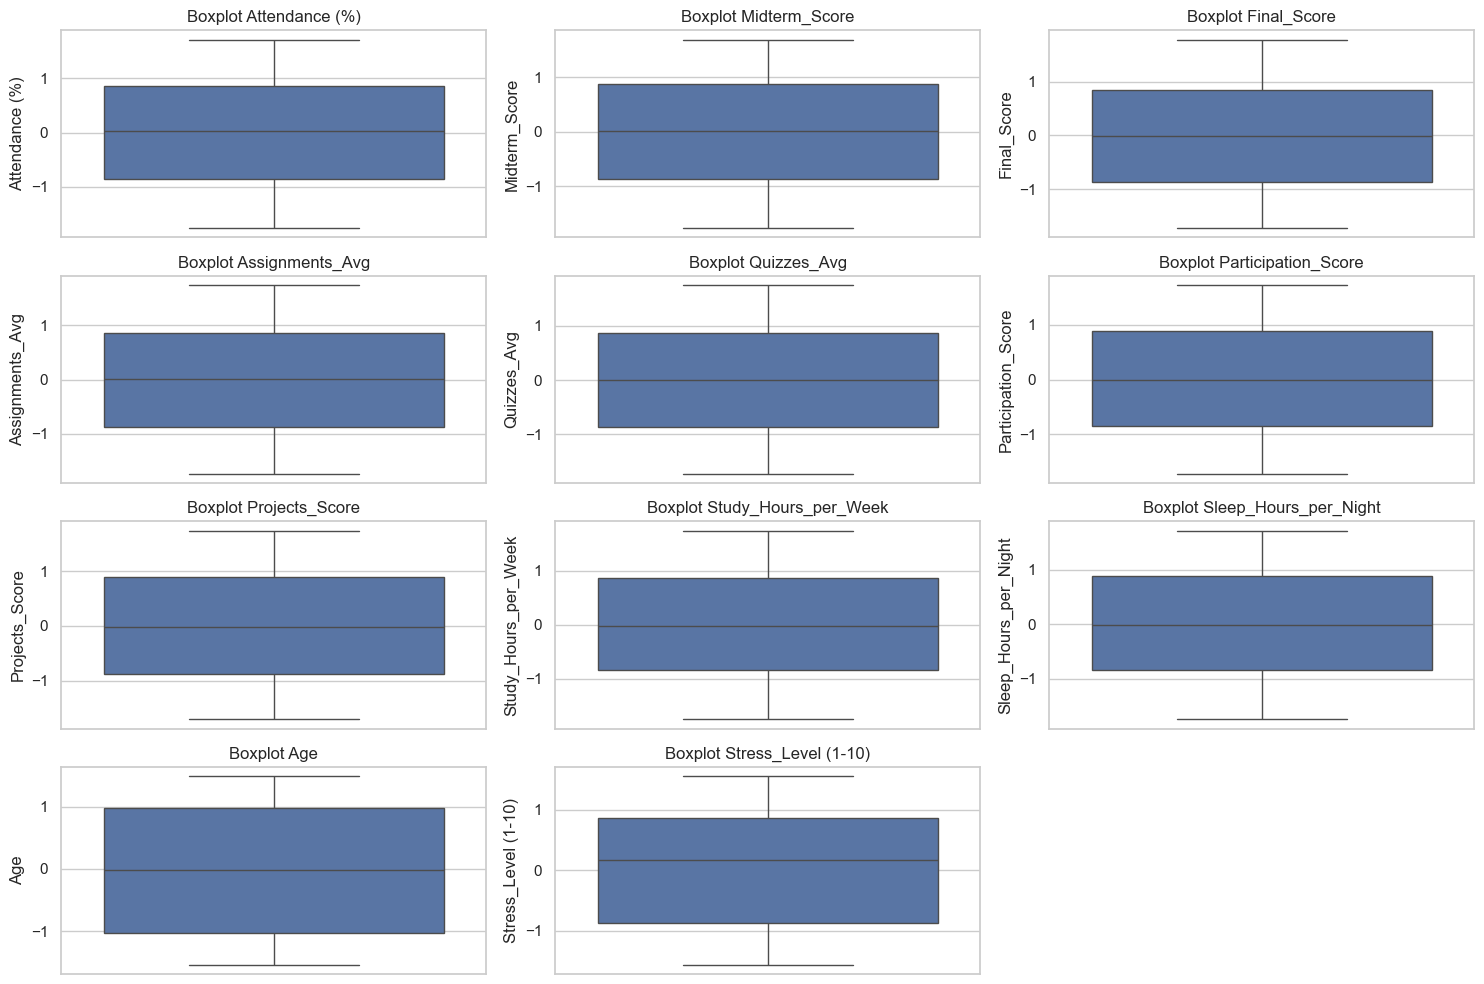

In [209]:
# Visualisasi distribusi untuk mendeteksi outlier (Boxplot)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f"Boxplot {col}")
plt.tight_layout()
plt.show()

In [210]:
# Pemeriksaan Outlier dengan IQR
outliers_iqr = {}
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    outliers_iqr[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound, 'outliers_count': len(outliers)}
    print(f"\nKolom {col}:")
    print(f"  Batas Bawah: {lower_bound:.2f}, Batas Atas: {upper_bound:.2f}")
    print(f"  Jumlah Outlier: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")


Kolom Attendance (%):
  Batas Bawah: -3.46, Batas Atas: 3.47
  Jumlah Outlier: 0 (0.00%)

Kolom Midterm_Score:
  Batas Bawah: -3.45, Batas Atas: 3.45
  Jumlah Outlier: 0 (0.00%)

Kolom Final_Score:
  Batas Bawah: -3.43, Batas Atas: 3.40
  Jumlah Outlier: 0 (0.00%)

Kolom Assignments_Avg:
  Batas Bawah: -3.48, Batas Atas: 3.47
  Jumlah Outlier: 0 (0.00%)

Kolom Quizzes_Avg:
  Batas Bawah: -3.46, Batas Atas: 3.46
  Jumlah Outlier: 0 (0.00%)

Kolom Participation_Score:
  Batas Bawah: -3.47, Batas Atas: 3.49
  Jumlah Outlier: 0 (0.00%)

Kolom Projects_Score:
  Batas Bawah: -3.53, Batas Atas: 3.53
  Jumlah Outlier: 0 (0.00%)

Kolom Study_Hours_per_Week:
  Batas Bawah: -3.38, Batas Atas: 3.40
  Jumlah Outlier: 0 (0.00%)

Kolom Sleep_Hours_per_Night:
  Batas Bawah: -3.43, Batas Atas: 3.48
  Jumlah Outlier: 0 (0.00%)

Kolom Age:
  Batas Bawah: -4.05, Batas Atas: 4.00
  Jumlah Outlier: 0 (0.00%)

Kolom Stress_Level (1-10):
  Batas Bawah: -3.47, Batas Atas: 3.46
  Jumlah Outlier: 0 (0.00%)


In [211]:
# Pemeriksaan Outlier dengan Z-score
outliers_zscore = {}
for col in numeric_columns:
    z_scores = np.abs((data[col] - data[col].mean()) / data[col].std())
    outliers = data[z_scores > 3][col]
    outliers_zscore[col] = {'outliers_count': len(outliers)}
    print(f"\nKolom {col}:")
    print(f"  Jumlah Outlier: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")


Kolom Attendance (%):
  Jumlah Outlier: 0 (0.00%)

Kolom Midterm_Score:
  Jumlah Outlier: 0 (0.00%)

Kolom Final_Score:
  Jumlah Outlier: 0 (0.00%)

Kolom Assignments_Avg:
  Jumlah Outlier: 0 (0.00%)

Kolom Quizzes_Avg:
  Jumlah Outlier: 0 (0.00%)

Kolom Participation_Score:
  Jumlah Outlier: 0 (0.00%)

Kolom Projects_Score:
  Jumlah Outlier: 0 (0.00%)

Kolom Study_Hours_per_Week:
  Jumlah Outlier: 0 (0.00%)

Kolom Sleep_Hours_per_Night:
  Jumlah Outlier: 0 (0.00%)

Kolom Age:
  Jumlah Outlier: 0 (0.00%)

Kolom Stress_Level (1-10):
  Jumlah Outlier: 0 (0.00%)


In [212]:
# Penanganan Outlier dengan Capping (Berdasarkan IQR)
print("Melakukan Capping Outlier dengan Batas IQR:")
data_capped = data.copy()
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_capped[col] = data_capped[col].clip(lower=lower_bound, upper=upper_bound)
    print(f"Capping kolom {col} pada batas [{lower_bound:.2f}, {upper_bound:.2f}]")

Melakukan Capping Outlier dengan Batas IQR:
Capping kolom Attendance (%) pada batas [-3.46, 3.47]
Capping kolom Midterm_Score pada batas [-3.45, 3.45]
Capping kolom Final_Score pada batas [-3.43, 3.40]
Capping kolom Assignments_Avg pada batas [-3.48, 3.47]
Capping kolom Quizzes_Avg pada batas [-3.46, 3.46]
Capping kolom Participation_Score pada batas [-3.47, 3.49]
Capping kolom Projects_Score pada batas [-3.53, 3.53]
Capping kolom Study_Hours_per_Week pada batas [-3.38, 3.40]
Capping kolom Sleep_Hours_per_Night pada batas [-3.43, 3.48]
Capping kolom Age pada batas [-4.05, 4.00]
Capping kolom Stress_Level (1-10) pada batas [-3.47, 3.46]


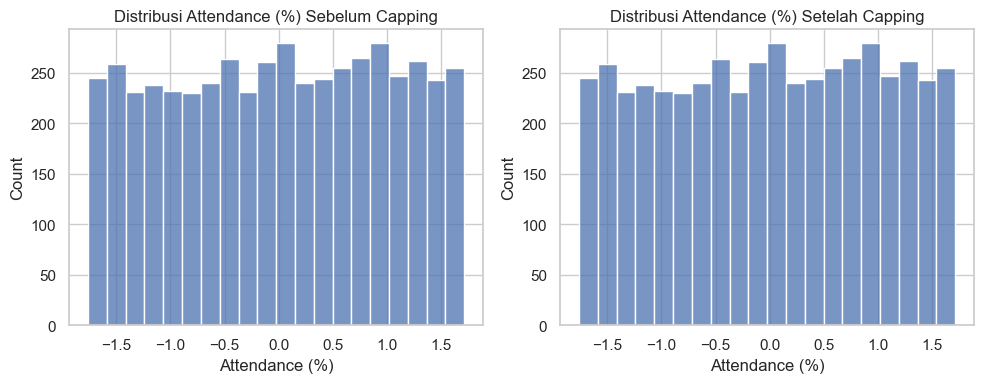

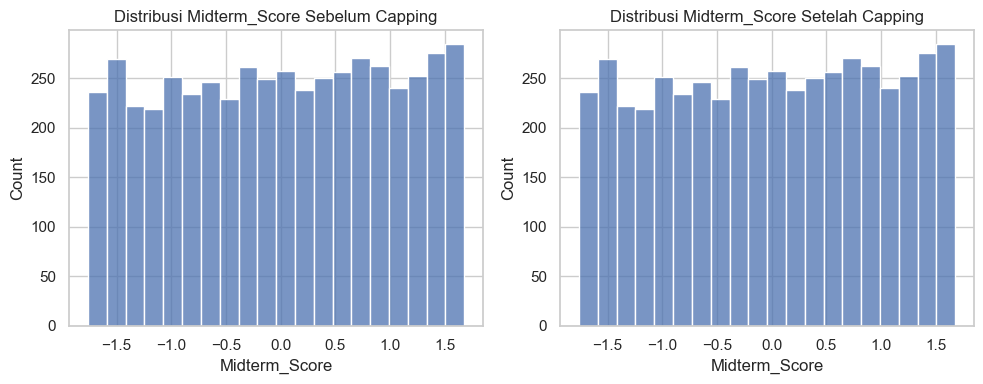

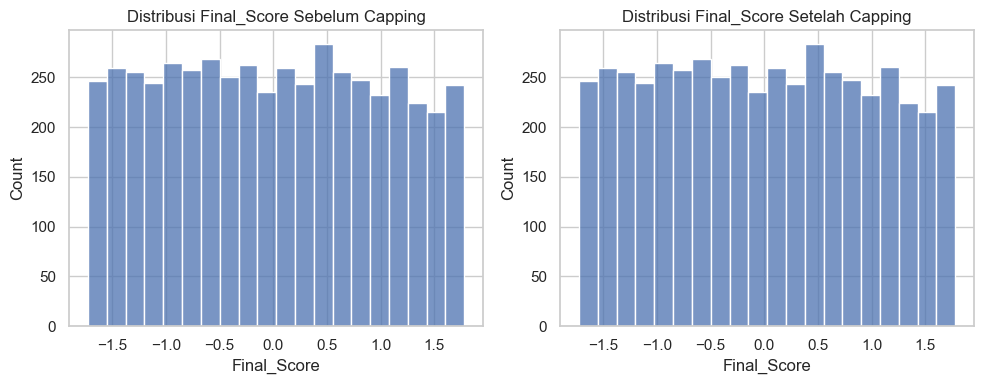

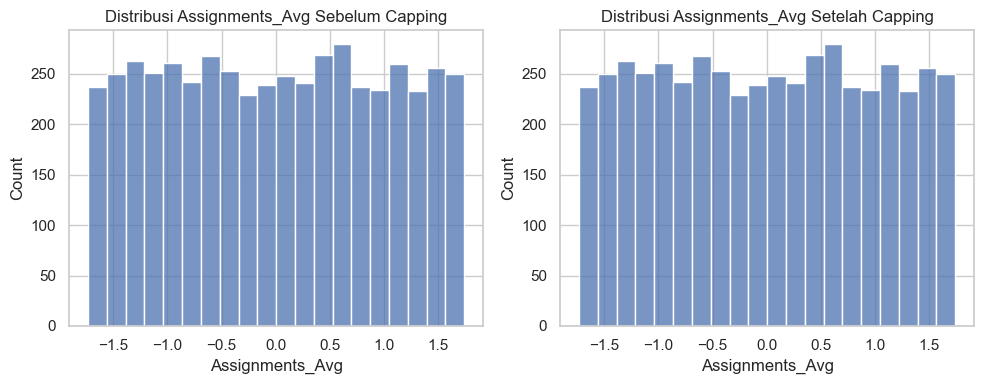

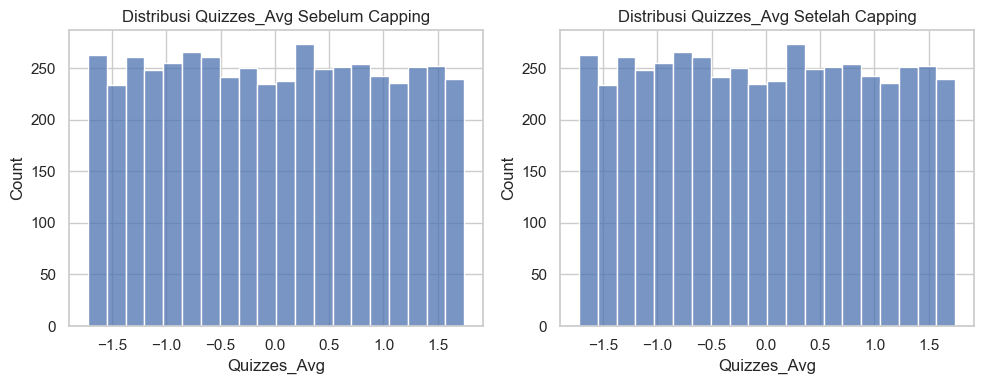

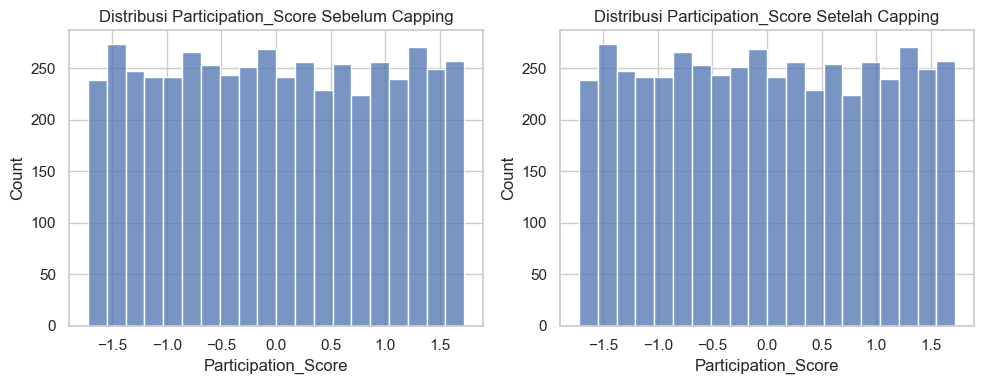

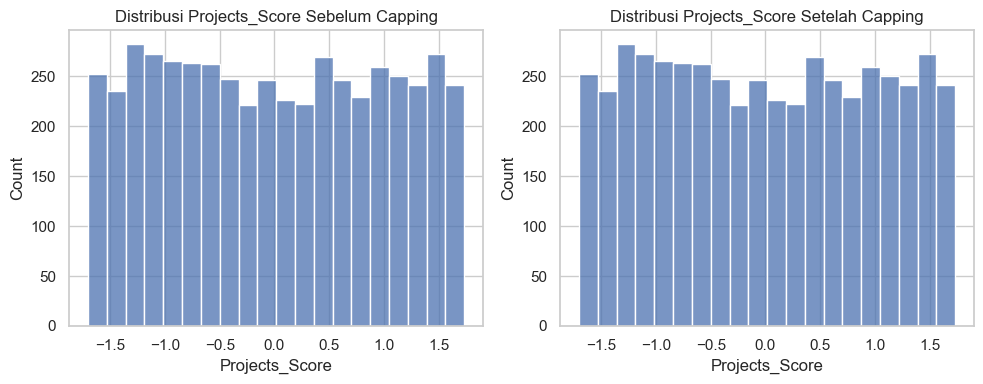

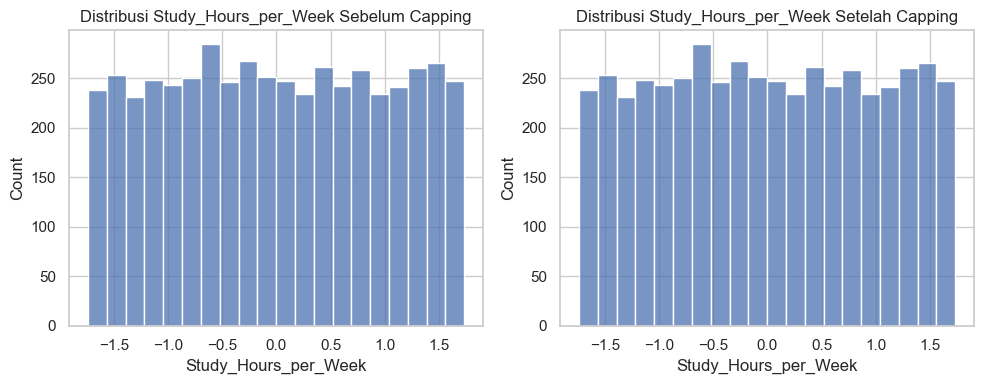

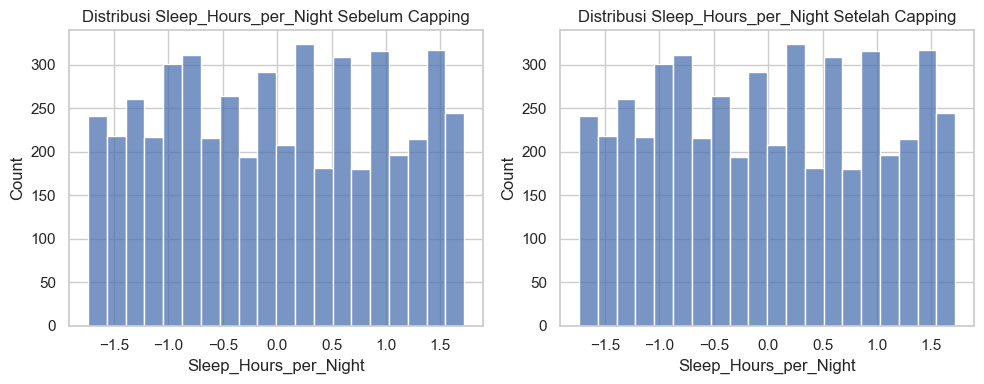

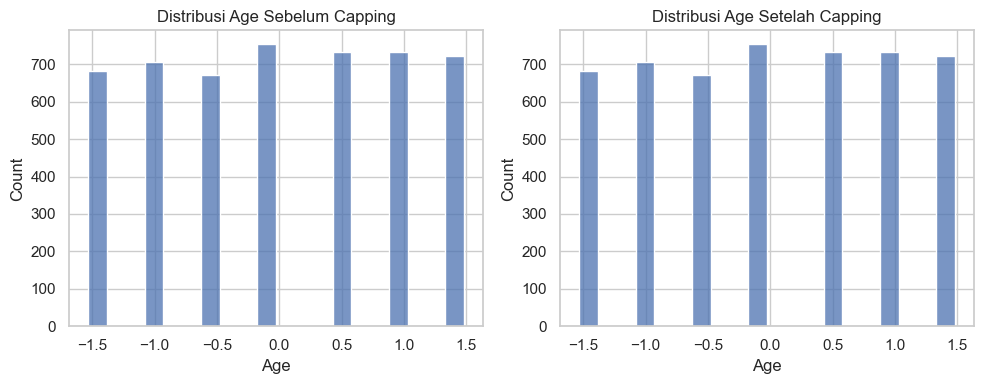

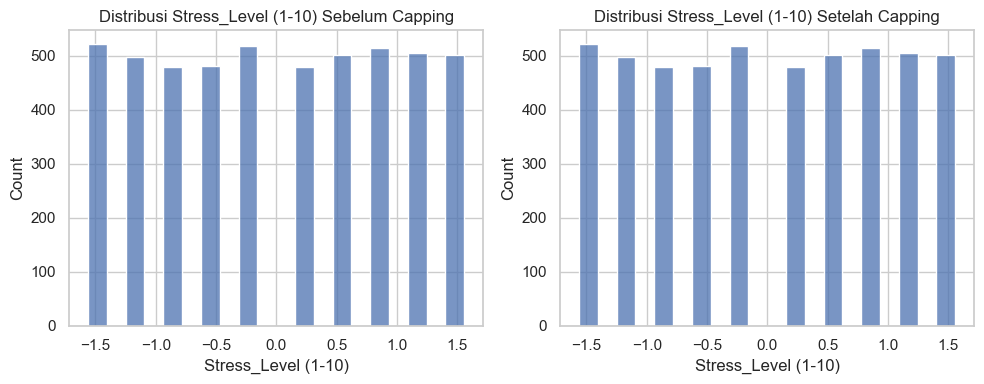

In [213]:
for col in numeric_columns:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], bins=20)
    plt.title(f"Distribusi {col} Sebelum Capping")
    plt.subplot(1, 2, 2)
    sns.histplot(data_capped[col], bins=20)
    plt.title(f"Distribusi {col} Setelah Capping")
    plt.tight_layout()
    plt.show()

#### Insight:

Berdasarkan pengecekan outliers diatas, terlihat bahwa tidak terdapat outliers pada setiap kolomnya, pun meski terdapat outliers, akan dihapus berdasarkan nilai IQR.

In [214]:
data_capped.to_csv("dataset/dataset_capped.csv", index=False)

### Pemilihan Fitur Awal

Tujuan

- Memilih fitur yang relevan untuk prediksi Total_Score berdasarkan kategori yang ditentukan:
  - Akademik: Attendance (%), Midterm_Score, Final_Score, Assignments_Avg, Quizzes_Avg, Participation_Score, Projects_Score.
  - Perilaku: Study_Hours_per_Week, Sleep_Hours_per_Night, Extracurricular_Activities.
  - Latar Belakang: Gender, Age, Department, Parent_Education_Level, Family_Income_Level, Internet_Access_at_Home.
  - Psikologis: Stress_Level.
- Mengidentifikasi dan menangani multikolinearitas (korelasi tinggi antar fitur, misalnya antara Midterm_Score dan Final_Score) menggunakan Pearson Correlation dan Variance Inflation Factor (VIF) untuk memastikan fitur yang dipilih tidak menyebabkan masalah pada model regresi.
- Menghasilkan dataset dengan fitur terpilih yang siap untuk pelatihan model.

In [215]:
data = pd.read_csv("dataset/dataset_capped.csv")

In [225]:
# Mendefinisikan fitur yang akan digunakan
# selected_features = [
#     'Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 
#     'Quizzes_Avg', 'Participation_Score', 'Projects_Score',  # Akademik
#     'Study_Hours_per_Week', 'Sleep_Hours_per_Night', 'Extracurricular_Activities',  # Perilaku
#     'Age', 'Parent_Education_Level', 'Internet_Access_at_Home',  # Latar Belakang
#     'Stress_Level (1-10)'  # Psikologis
# ]

selected_features = [
    'Attendance (%)',
    'Participation_Score',
    'Study_Hours_per_Week',
    'Sleep_Hours_per_Night',
    'Stress_Level (1-10)'
]

data['Average_Score'] = (data['Midterm_Score'] + data['Final_Score'] + data['Assignments_Avg'] + 
                       data['Quizzes_Avg'] + data['Projects_Score']) / 5

In [226]:
# Menambahkan kolom hasil One-Hot Encoding untuk Gender, Department, Family_Income_Level
one_hot_columns = [col for col in data.columns if col.startswith(('Gender_', 'Department_', 'Family_Income_Level_'))]
selected_features.extend(one_hot_columns)

In [227]:
# Memilih fitur dan menghapus kolom yang tidak relevan
columns_to_drop = ['Student_ID', 'First_Name', 'Last_Name', 'Email']
data_selected = data[selected_features + ['Total_Score']].copy()  # Sertakan Total_Score sebagai target

In [228]:
# Verifikasi fitur yang dipilih
print("\nFitur yang Dipilih:")
print(selected_features)
print("\nPratinjau Dataset Setelah Pemilihan Fitur (5 Baris Pertama):")
print(data_selected.head())


Fitur yang Dipilih:
['Attendance (%)', 'Participation_Score', 'Study_Hours_per_Week', 'Sleep_Hours_per_Night', 'Stress_Level (1-10)', 'Gender_Male', 'Department_CS', 'Department_Engineering', 'Department_Mathematics', 'Family_Income_Level_Low', 'Family_Income_Level_Medium']

Pratinjau Dataset Setelah Pemilihan Fitur (5 Baris Pertama):
   Attendance (%)  Participation_Score  Study_Hours_per_Week  \
0        1.528977             0.808513             -1.004008   
1        1.553297             1.312189              1.331819   
2        1.679067            -1.561524             -0.712029   
3        1.043960            -1.578773              1.109359   
4       -1.108038             0.494578             -0.586896   

   Sleep_Hours_per_Night  Stress_Level (1-10)  Gender_Male  Department_CS  \
0              -0.424907            -1.561545        False          False   
1              -1.531400            -0.522178         True          False   
2              -0.286595             1.210100 

In [230]:
# Analisis Korelasi dengan Pearson Correlation
print("Menghitung Matriks Korelasi Pearson untuk Fitur Numerik:")
correlation_matrix = data_selected[selected_features].corr(method='pearson')

Menghitung Matriks Korelasi Pearson untuk Fitur Numerik:


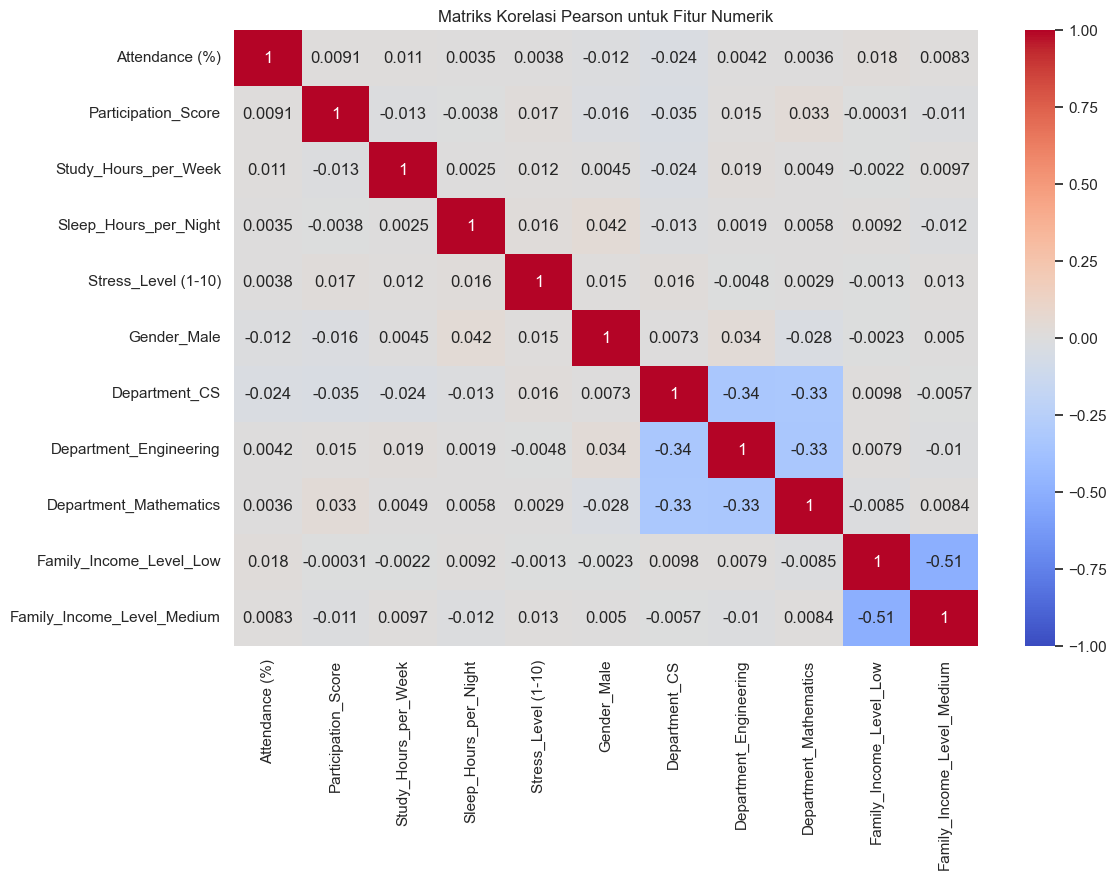

In [231]:
# Visualisasi heatmap korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Matriks Korelasi Pearson untuk Fitur Numerik")
plt.show()

In [232]:
# Identifikasi pasangan fitur dengan korelasi tinggi (|r| > 0.8)
print("\nPasangan Fitur dengan Korelasi Tinggi (|r| > 0.8):")
corr_pairs = correlation_matrix.unstack()
high_corr = corr_pairs[(abs(corr_pairs) > 0.8) & (abs(corr_pairs) < 1.0)]
high_corr


Pasangan Fitur dengan Korelasi Tinggi (|r| > 0.8):


Series([], dtype: float64)

In [233]:
data_selected.to_csv("dataset/dataset_selected_features.csv", index=False)

### Pembagian Data

Tujuan

- Memisahkan dataset menjadi data pelatihan (80%) dan data pengujian (20%) menggunakan fungsi train-test split untuk mempersiapkan data bagi pelatihan dan evaluasi model regresi.
- Menerapkan stratified sampling (jika memungkinkan) untuk memastikan distribusi fitur kategorikal seperti Department seimbang antara data pelatihan dan pengujian, meskipun Total_Score adalah variabel kontinu.
- Mengatur 5-fold cross-validation pada data pelatihan untuk mengevaluasi model secara robust, meminimalkan risiko overfitting, dan mendapatkan estimasi performa yang stabil.

In [234]:
from sklearn.model_selection import train_test_split, KFold

In [235]:
data = pd.read_csv("dataset/dataset_selected_features.csv")

In [236]:
# Binning Total_Score untuk stratified sampling
print("Melakukan Binning pada Total_Score untuk Stratified Sampling:")
# Misalnya, bagi Total_Score ke dalam 5 kelas berdasarkan kuantil
data['Total_Score_Bin'] = pd.qcut(data['Total_Score'], q=5, labels=False)
print("Distribusi Total_Score_Bin:")
print(data['Total_Score_Bin'].value_counts().sort_index())

Melakukan Binning pada Total_Score untuk Stratified Sampling:
Distribusi Total_Score_Bin:
Total_Score_Bin
0    1000
1    1000
2    1000
3    1000
4    1000
Name: count, dtype: int64


In [237]:
# Pisahkan fitur (X) dan target (y)
X = data.drop(columns=['Total_Score', 'Total_Score_Bin'])
y = data['Total_Score']
stratify_col = data['Total_Score_Bin']

In [238]:
# Train-Test Split dengan Stratified Sampling
print("Melakukan Train-Test Split (80% Pelatihan, 20% Pengujian):")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_col
)

Melakukan Train-Test Split (80% Pelatihan, 20% Pengujian):


In [239]:
# Verifikasi distribusi Total_Score antara pelatihan dan pengujian
print("Statistik Total_Score pada Data Pelatihan dan Pengujian:")
print("Pelatihan:")
print(y_train.describe())
print("Pengujian:")
print(y_test.describe())

Statistik Total_Score pada Data Pelatihan dan Pengujian:
Pelatihan:
count    4000.00000
mean       75.04520
std        14.35151
min        50.01000
25%        62.70750
50%        75.38000
75%        87.17000
max        99.99000
Name: Total_Score, dtype: float64
Pengujian:
count    1000.000000
mean       74.928500
std        14.216382
min        50.040000
25%        62.757500
50%        75.225000
75%        86.705000
max        99.990000
Name: Total_Score, dtype: float64


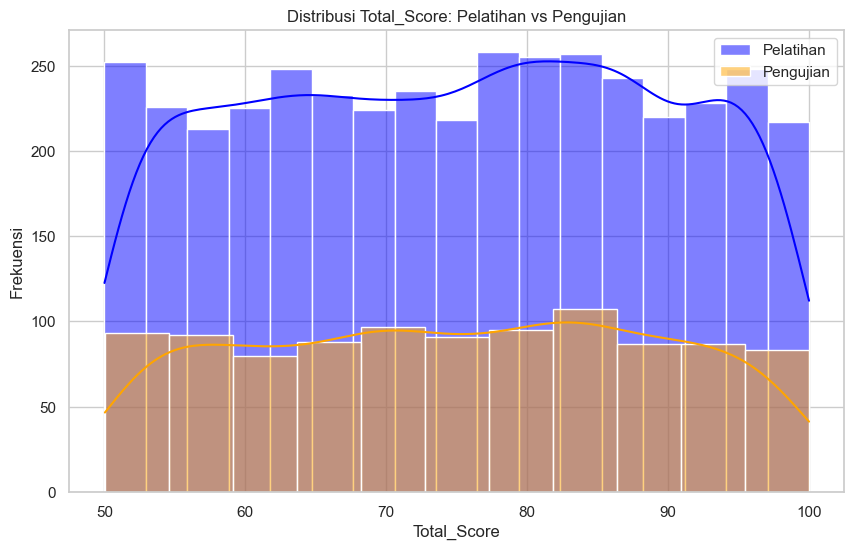

In [240]:
# Visualisasi distribusi Total_Score
plt.figure(figsize=(10, 6))
sns.histplot(y_train, label='Pelatihan', kde=True, color='blue', alpha=0.5)
sns.histplot(y_test, label='Pengujian', kde=True, color='orange', alpha=0.5)
plt.title('Distribusi Total_Score: Pelatihan vs Pengujian')
plt.xlabel('Total_Score')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

In [241]:
# Konfigurasi 5-Fold Cross-Validation
print("Mengatur 5-Fold Cross-Validation untuk Data Pelatihan:")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices = list(kf.split(X_train))
print(f"Jumlah Lipatan: {len(fold_indices)}")
for i, (train_idx, val_idx) in enumerate(fold_indices, 1):
    print(f"Lipatan {i}: {len(train_idx)} data pelatihan, {len(val_idx)} data validasi")

Mengatur 5-Fold Cross-Validation untuk Data Pelatihan:
Jumlah Lipatan: 5
Lipatan 1: 3200 data pelatihan, 800 data validasi
Lipatan 2: 3200 data pelatihan, 800 data validasi
Lipatan 3: 3200 data pelatihan, 800 data validasi
Lipatan 4: 3200 data pelatihan, 800 data validasi
Lipatan 5: 3200 data pelatihan, 800 data validasi


In [242]:
X_train.to_csv("dataset/X_train.csv", index=False)
X_test.to_csv("dataset/X_test.csv", index=False)
y_train.to_csv("dataset/y_train.csv", index=False)
y_test.to_csv("dataset/y_test.csv", index=False)

## Pelatihan Model Regresi Linear

Tujuan

- Melatih model Linear Regression menggunakan data pelatihan (X_train, y_train) untuk memprediksi Total_Score.
- Mengevaluasi performa model pada data pelatihan menggunakan 5-fold cross-validation untuk memastikan robustnes dan mencegah overfitting.
- Mengevaluasi performa akhir pada data pengujian (X_test, y_test) menggunakan metrik evaluasi:
  - Mean Absolute Error (MAE): Rata-rata kesalahan absolut.
  - Root Mean Squared Error (RMSE): Akar kuadrat rata-rata kesalahan kuadrat, sensitif terhadap kesalahan besar.
  - R² Score: Proporsi variansi Total_Score yang dijelaskan oleh model.

In [243]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [244]:
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv")
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv")

In [245]:
# Konversi y_train dan y_test ke array 1D
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [246]:
# Inisialisasi dan pelatihan model Linear Regression
print("Melatih Model Linear Regression...")
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

Melatih Model Linear Regression...


LinearRegression()

In [247]:
# Evaluasi dengan 5-Fold Cross-Validation pada data pelatihan
print("Melakukan 5-Fold Cross-Validation pada Data Pelatihan...")
# MAE (negatif karena cross_val_score memaksimalkan skor)
mae_scores = -cross_val_score(model_lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
# RMSE (negatif karena cross_val_score memaksimalkan skor)
rmse_scores = np.sqrt(-cross_val_score(model_lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
# R²
r2_scores = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='r2')

print("Hasil 5-Fold Cross-Validation:")
print(f"MAE: Mean = {mae_scores.mean():.4f}, Std = {mae_scores.std():.4f}")
print(f"RMSE: Mean = {rmse_scores.mean():.4f}, Std = {rmse_scores.std():.4f}")
print(f"R²: Mean = {r2_scores.mean():.4f}, Std = {r2_scores.std():.4f}")

Melakukan 5-Fold Cross-Validation pada Data Pelatihan...
Hasil 5-Fold Cross-Validation:
MAE: Mean = 12.4402, Std = 0.3184
RMSE: Mean = 14.3913, Std = 0.2643
R²: Mean = -0.0068, Std = 0.0046


In [248]:
# Prediksi pada data pengujian
print("\nMembuat Prediksi pada Data Pengujian...")
y_pred = model_lr.predict(X_test)

# Evaluasi pada data pengujian
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\nHasil Evaluasi pada Data Pengujian:")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")


Membuat Prediksi pada Data Pengujian...

Hasil Evaluasi pada Data Pengujian:
MAE: 12.2395
RMSE: 14.1924
R²: 0.0024


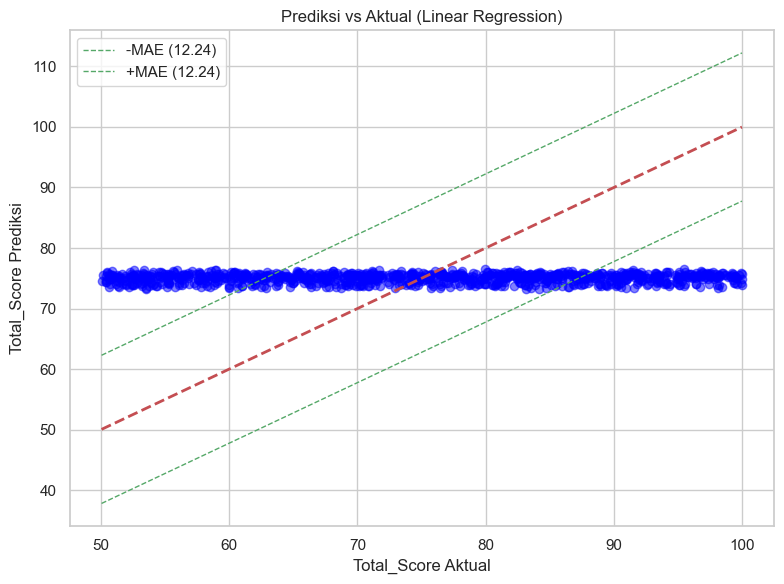

In [249]:
# Visualisasi Prediksi vs Nilai Aktual

mae_test = mean_absolute_error(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min() - mae_test, y_test.max() - mae_test], 'g--', lw=1, label=f'-MAE ({mae_test:.2f})')
plt.plot([y_test.min(), y_test.max()], [y_test.min() + mae_test, y_test.max() + mae_test], 'g--', lw=1, label=f'+MAE ({mae_test:.2f})')
plt.xlabel('Total_Score Aktual')
plt.ylabel('Total_Score Prediksi')
plt.title('Prediksi vs Aktual (Linear Regression)')
plt.legend()
plt.tight_layout()
plt.show()

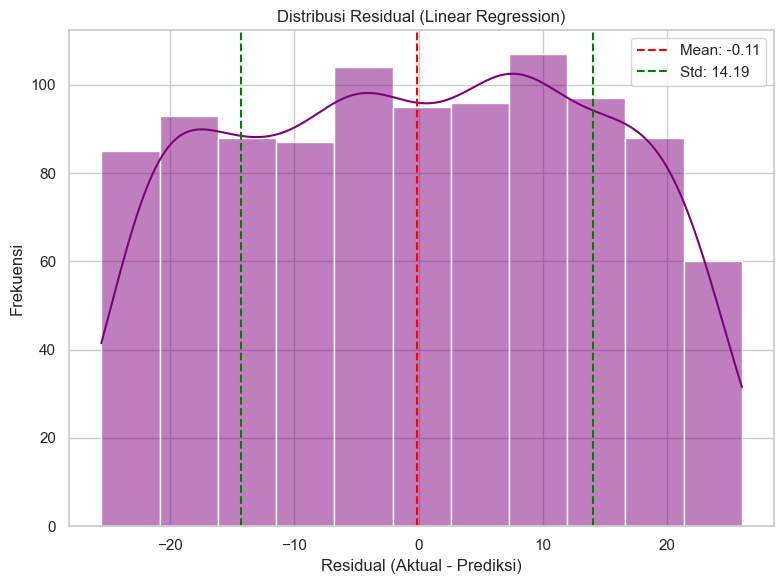

In [250]:
# Analisis Residual

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
plt.axvline(residuals.mean() + residuals.std(), color='green', linestyle='--', label=f'Std: {residuals.std():.2f}')
plt.axvline(residuals.mean() - residuals.std(), color='green', linestyle='--')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Residual (Linear Regression)')
plt.legend()
plt.tight_layout()
plt.show()

In [251]:
# Simpan model dan metrik evaluasi
joblib.dump(model_lr, "linear_regression_model.pkl")

# Simpan metrik evaluasi
metrics = {
    'Model': 'Linear Regression',
    'CV_MAE_Mean': mae_scores.mean(),
    'CV_MAE_Std': mae_scores.std(),
    'CV_RMSE_Mean': rmse_scores.mean(),
    'CV_RMSE_Std': rmse_scores.std(),
    'CV_R2_Mean': r2_scores.mean(),
    'CV_R2_Std': r2_scores.std(),
    'Test_MAE': mae_test,
    'Test_RMSE': rmse_test,
    'Test_R2': r2_test
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("linear_regression_metrics.csv", index=False)

In [252]:
# Memuat data
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv").values.ravel()
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv").values.ravel()

# Verifikasi data
print("\nJumlah Kolom Fitur pada X_train:", X_train.shape[1])
print("Pratinjau X_train (5 Baris):")
print(X_train.head())
print("\nStatistik y_train:")
print(pd.Series(y_train).describe())
print("\nStatistik y_test:")
print(pd.Series(y_test).describe())

# Cek apakah ada fitur kosong
print("\nCek Nilai Kosong pada X_train:")
print(X_train.isnull().sum())

# Latih model dan prediksi
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

# Cek prediksi
print("\nRata-rata Prediksi:", np.mean(y_pred))
print("Rentang Prediksi:", [np.min(y_pred), np.max(y_pred)])
print("Rata-rata Aktual:", np.mean(y_test))
print("Rentang Aktual:", [np.min(y_test), np.max(y_test)])


Jumlah Kolom Fitur pada X_train: 11
Pratinjau X_train (5 Baris):
   Attendance (%)  Participation_Score  Study_Hours_per_Week  \
0        0.881362            -0.823259              1.053744   
1       -0.819668            -0.530023             -0.030747   
2       -1.020485            -0.136742             -1.393312   
3       -0.222084             1.294940             -0.614703   
4       -0.201933            -1.351084              0.191713   

   Sleep_Hours_per_Night  Stress_Level (1-10)  Gender_Male  Department_CS  \
0              -0.701530            -0.522178         True           True   
1               0.612430            -1.561545         True          False   
2              -0.424907             0.517189         True          False   
3              -1.185621             0.517189        False          False   
4               0.889053             0.863644        False          False   

   Department_Engineering  Department_Mathematics  Family_Income_Level_Low  \
0       

### Interpretasi

1. Prediksi Sangat Terbatas (Garis Horizontal):

- Rentang prediksi hanya 71.93 hingga 78.27, yang sangat sempit (selisih ~6.34 poin).
= Hal ini menjelaskan mengapa scatter plot membentuk garis horizontal di sekitar rentang 70-80: model regresi linear menghasilkan prediksi yang hampir konstan, terlepas dari variasi nilai aktual.
- Rata-rata prediksi (75.04) sangat dekat dengan rata-rata aktual (74.93), menunjukkan model cenderung memprediksi nilai rata-rata dari data pelatihan, tanpa menangkap variasi yang lebih luas.

2. Variasi Aktual Jauh Lebih Besar:

- Rentang aktual Total_Score adalah 50.04 hingga 99.99 (selisih ~49.95 poin), yang menunjukkan variasi yang signifikan dalam data pengujian.
- Namun, model gagal menangkap variasi ini, karena prediksi hanya berkisar dalam rentang kecil (71.93-78.27). Hal ini berarti model tidak mampu membedakan antara data dengan Total_Score rendah (50) dan tinggi (99).

3. Implikasi:

- Model Tidak Belajar Pola dengan Baik: Regresi linear sepertinya tidak dapat menangkap hubungan antara fitur dan Total_Score, sehingga hanya memprediksi nilai rata-rata (~75).

In [253]:
import pandas as pd
import numpy as np

# Memuat data
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv").values.ravel()

# Hitung korelasi absolut
correlation_matrix = X_train.corrwith(pd.Series(y_train)).abs()
print("\nKorelasi Absolut dengan Total_Score (Top 10):")
print(correlation_matrix.sort_values(ascending=False).head(10))


Korelasi Absolut dengan Total_Score (Top 10):
Department_Mathematics        0.025839
Sleep_Hours_per_Night         0.018046
Department_Engineering        0.011496
Family_Income_Level_Medium    0.009871
Stress_Level (1-10)           0.006785
Participation_Score           0.005185
Attendance (%)                0.005025
Department_CS                 0.003629
Gender_Male                   0.003260
Study_Hours_per_Week          0.001776
dtype: float64


### Interpretasi
1. Korelasi Sangat Rendah:
- Korelasi tertinggi adalah Projects_Score dengan nilai 0.034784, yang sangat rendah (<0.05).
- Semua fitur dalam daftar Top 10 memiliki korelasi di bawah 0.04, menunjukkan bahwa tidak ada fitur yang memiliki hubungan linier yang kuat dengan Total_Score.
- Dalam regresi linear, korelasi rendah berarti fitur tidak cukup informatif untuk menjelaskan variasi Total_Score, sehingga model cenderung memprediksi nilai rata-rata (~75), yang konsisten dengan rentang prediksi sempit (71.93-78.27) dan garis horizontal pada scatter plot.

2. Tidak Ada Fitur Dominan:
- Fitur seperti Final_Score, Assignments_Avg, dan Projects_Score seharusnya memiliki korelasi lebih tinggi dengan Total_Score (misalnya, >0.5), karena secara logis nilai akademik biasanya berkorelasi kuat dengan skor total. Namun, korelasi yang sangat rendah (<0.03) menunjukkan:
  - Data Mungkin Banyak Noise: Data bisa jadi memiliki banyak noise atau variasi acak yang tidak dapat dijelaskan oleh fitur saat ini.
- Transformasi atau Capping Berlebihan: Langkah sebelumnya seperti capping outlier atau standarisasi mungkin telah mengurangi variasi fitur, sehingga korelasi menjadi rendah.
  - Hubungan Non-Linear: Hubungan antara fitur dan Total_Score mungkin non-linear, sehingga korelasi Pearson (yang mengukur hubungan linier) tidak dapat menangkap pola tersebut.

3. Implikasi untuk Regresi Linear:
- Regresi linear sangat bergantung pada hubungan linier antara fitur dan target. Dengan korelasi <0.04, model tidak dapat menangkap variasi Total_Score (rentang aktual 50-100), sehingga hanya memprediksi nilai rata-rata (~75).
- Hal ini menjelaskan mengapa scatter plot menunjukkan garis horizontal: model gagal membedakan antara Total_Score rendah (50) dan tinggi (100), karena fitur tidak memberikan informasi yang cukup.

## Pelatihan Model Ridge Regression

Tujuan

- Melatih model Ridge Regression untuk memprediksi Total_Score, dengan regularisasi L2 untuk menangani potensi multikolinearitas atau overfitting, meskipun korelasi fitur dengan Total_Score sangat rendah (<0.04) berdasarkan analisis sebelumnya.
- Menggunakan GridSearchCV untuk menentukan nilai optimal dari parameter alpha (koefisien regulasi) berdasarkan performa cross-validation.
- Mengevaluasi performa model pada data pelatihan dengan 5-fold cross-validation dan pada data pengujian untuk memastikan generalisasi yang baik.

In [254]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [255]:
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv").values.ravel()
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv").values.ravel()

In [256]:
print("\nJumlah Data Pelatihan:", len(X_train))
print("Jumlah Data Pengujian:", len(X_test))


Jumlah Data Pelatihan: 4000
Jumlah Data Pengujian: 1000


In [257]:
# Inisialisasi model Ridge dan GridSearchCV untuk tuning alpha
print("Melakukan Tuning Hyperparameter dengan GridSearchCV...")
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(ridge, param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

Melakukan Tuning Hyperparameter dengan GridSearchCV...


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}, scoring='r2')

In [258]:
# Tampilkan hasil tuning
print("Hasil GridSearchCV:")
print(f"Alpha Terbaik: {grid_search.best_params_['alpha']}")
print(f"R² Terbaik pada Cross-Validation: {grid_search.best_score_:.4f}")

Hasil GridSearchCV:
Alpha Terbaik: 100.0
R² Terbaik pada Cross-Validation: -0.0054


In [259]:
# Latih model dengan alpha optimal
best_ridge = grid_search.best_estimator_
best_ridge.fit(X_train, y_train)

Ridge(alpha=100.0)

In [260]:
# Evaluasi dengan 5-Fold Cross-Validation pada data pelatihan
print("Melakukan 5-Fold Cross-Validation pada Data Pelatihan...")
mae_scores = -cross_val_score(best_ridge, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(best_ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(best_ridge, X_train, y_train, cv=5, scoring='r2')

print("\nHasil 5-Fold Cross-Validation:")
print(f"MAE: Mean = {mae_scores.mean():.4f}, Std = {mae_scores.std():.4f}")
print(f"RMSE: Mean = {rmse_scores.mean():.4f}, Std = {rmse_scores.std():.4f}")
print(f"R²: Mean = {r2_scores.mean():.4f}, Std = {r2_scores.std():.4f}")

Melakukan 5-Fold Cross-Validation pada Data Pelatihan...

Hasil 5-Fold Cross-Validation:
MAE: Mean = 12.4377, Std = 0.3203
RMSE: Mean = 14.3870, Std = 0.2670
R²: Mean = -0.0062, Std = 0.0042


In [261]:
# Prediksi pada data pengujian
print("Membuat Prediksi pada Data Pengujian...")
y_pred = best_ridge.predict(X_test)

# Evaluasi pada data pengujian
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\nHasil Evaluasi pada Data Pengujian:")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Membuat Prediksi pada Data Pengujian...

Hasil Evaluasi pada Data Pengujian:
MAE: 12.2420
RMSE: 14.1933
R²: 0.0022


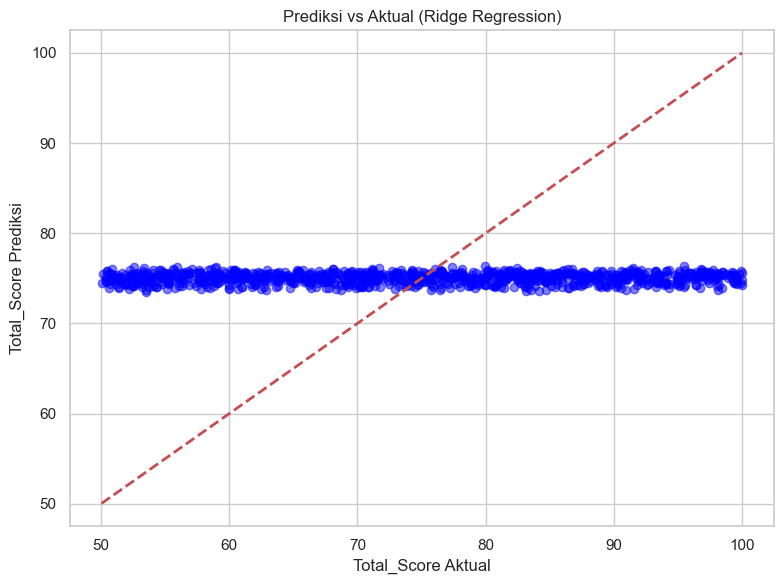

In [262]:
# Visualisasi Prediksi vs Nilai Aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Total_Score Aktual')
plt.ylabel('Total_Score Prediksi')
plt.title('Prediksi vs Aktual (Ridge Regression)')
plt.tight_layout()
plt.show()

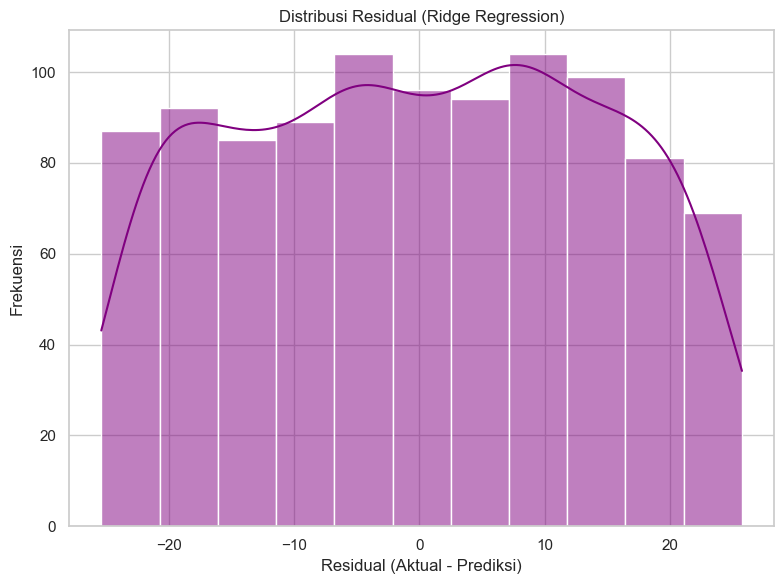

In [263]:
# Analisis Residual
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Residual (Ridge Regression)')
plt.tight_layout()
plt.show()

In [264]:
# Simpan model dan metrik evaluasi
joblib.dump(best_ridge, "ridge_regression_model.pkl")

# Simpan metrik evaluasi
metrics = {
    'Model': 'Ridge Regression',
    'Best_Alpha': grid_search.best_params_['alpha'],
    'CV_MAE_Mean': mae_scores.mean(),
    'CV_MAE_Std': mae_scores.std(),
    'CV_RMSE_Mean': rmse_scores.mean(),
    'CV_RMSE_Std': rmse_scores.std(),
    'CV_R2_Mean': r2_scores.mean(),
    'CV_R2_Std': r2_scores.std(),
    'Test_MAE': mae_test,
    'Test_RMSE': rmse_test,
    'Test_R2': r2_test
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("ridge_regression_metrics.csv", index=False)

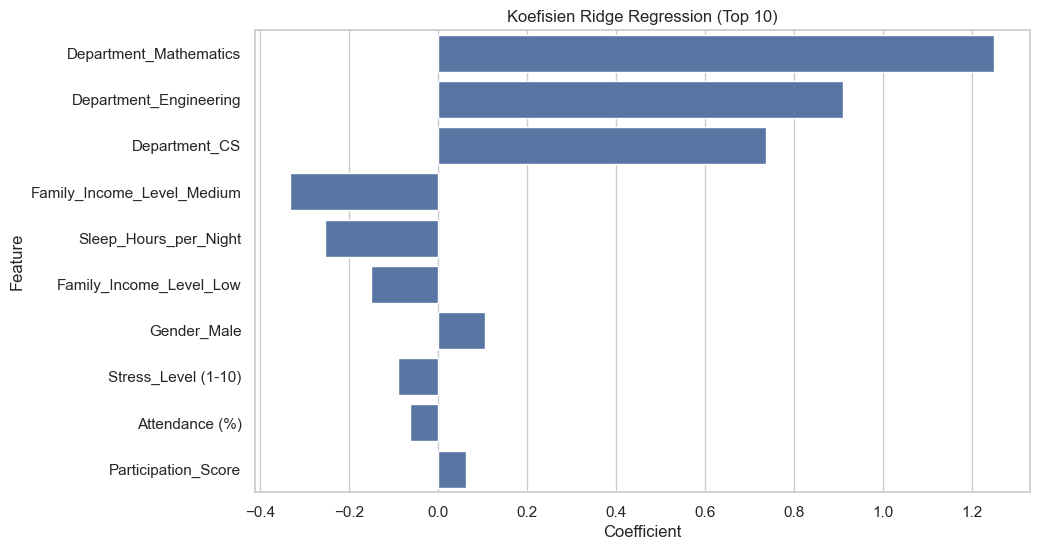

In [265]:
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': best_ridge.coef_})
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient', key=abs, ascending=False).head(10))
plt.title('Koefisien Ridge Regression (Top 10)')
plt.show()

### Interpretasi

Ridge Regression tidak meningkatkan performa secara signifikan dibandingkan Linear Regression, karena masalah utama adalah korelasi rendah dan kemungkinan hubungan non-linear, bukan overfitting atau multikolinearitas.

## Pelatihan Model Random Forest Regressor

Tujuan

- Melatih model Random Forest Regressor untuk memprediksi Total_Score, yang dirancang untuk menangkap hubungan non-linear dan interaksi antar fitur, mengingat korelasi linier yang sangat rendah (<0.04) dari analisis sebelumnya.
- Menggunakan GridSearchCV untuk menentukan kombinasi optimal dari hyperparameter berdasarkan performa cross-validation.
- Mengevaluasi performa model pada data pelatihan dengan 5-fold cross-validation dan pada data pengujian untuk memastikan generalisasi yang baik.

In [266]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [267]:
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv").values.ravel()
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv").values.ravel()

In [268]:
# Inisialisasi model Random Forest dan GridSearchCV untuk tuning hyperparameter
print("\nMelakukan Tuning Hyperparameter dengan GridSearchCV...")
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Tampilkan hasil tuning
print("\nHasil GridSearchCV:")
print(f"Hyperparameter Terbaik: {grid_search.best_params_}")
print(f"R² Terbaik pada Cross-Validation: {grid_search.best_score_:.4f}")


Melakukan Tuning Hyperparameter dengan GridSearchCV...

Hasil GridSearchCV:
Hyperparameter Terbaik: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
R² Terbaik pada Cross-Validation: -0.0163


In [269]:
# Latih model dengan hyperparameter optimal
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200,
                      random_state=42)

In [270]:
# Evaluasi dengan 5-Fold Cross-Validation pada data pelatihan
print("\nMelakukan 5-Fold Cross-Validation pada Data Pelatihan...")
mae_scores = -cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')

print("\nHasil 5-Fold Cross-Validation:")
print(f"MAE: Mean = {mae_scores.mean():.4f}, Std = {mae_scores.std():.4f}")
print(f"RMSE: Mean = {rmse_scores.mean():.4f}, Std = {rmse_scores.std():.4f}")
print(f"R²: Mean = {r2_scores.mean():.4f}, Std = {r2_scores.std():.4f}")


Melakukan 5-Fold Cross-Validation pada Data Pelatihan...

Hasil 5-Fold Cross-Validation:
MAE: Mean = 12.4705, Std = 0.2746
RMSE: Mean = 14.4534, Std = 0.2301
R²: Mean = -0.0156, Std = 0.0121


In [271]:
# Prediksi pada data pengujian
print("\nMembuat Prediksi pada Data Pengujian...")
y_pred = best_rf.predict(X_test)


Membuat Prediksi pada Data Pengujian...


In [272]:
# Evaluasi pada data pengujian
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\nHasil Evaluasi pada Data Pengujian:")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")


Hasil Evaluasi pada Data Pengujian:
MAE: 12.2676
RMSE: 14.2582
R²: -0.0069


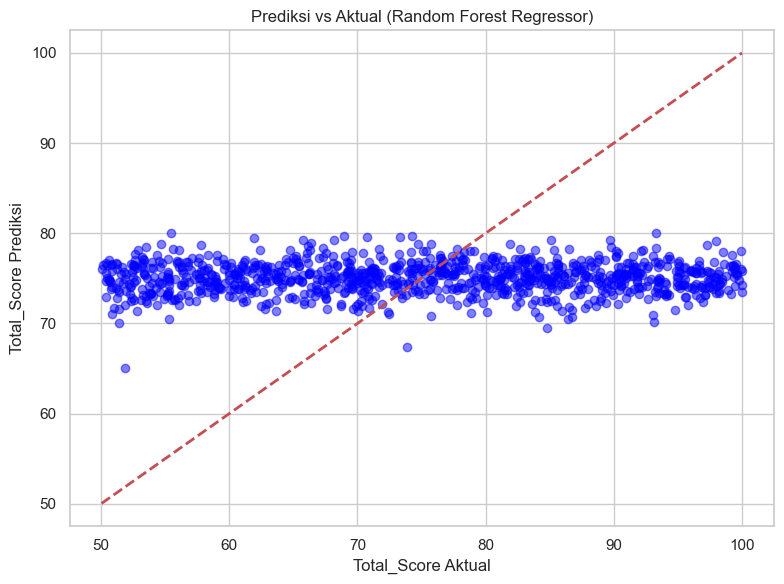

In [273]:
# Visualisasi Prediksi vs Nilai Aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Total_Score Aktual')
plt.ylabel('Total_Score Prediksi')
plt.title('Prediksi vs Aktual (Random Forest Regressor)')
plt.tight_layout()
plt.show()

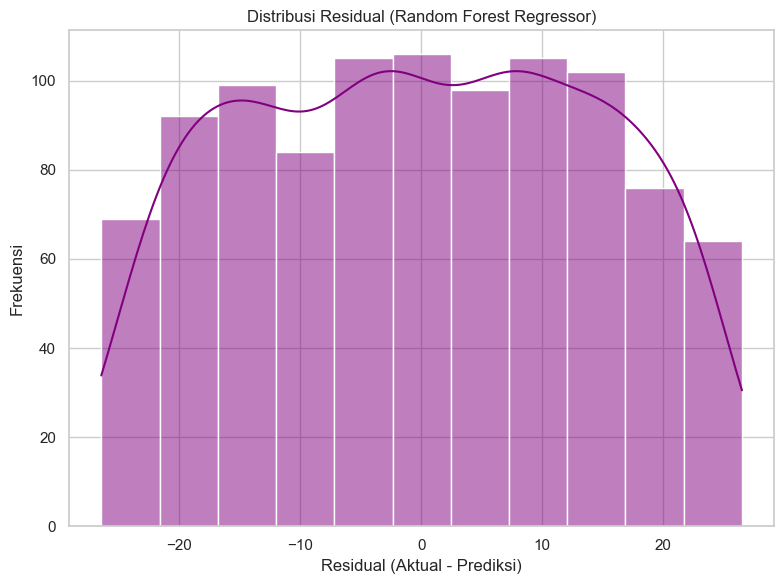

In [274]:
# Analisis Residual
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Residual (Random Forest Regressor)')
plt.tight_layout()
plt.show()

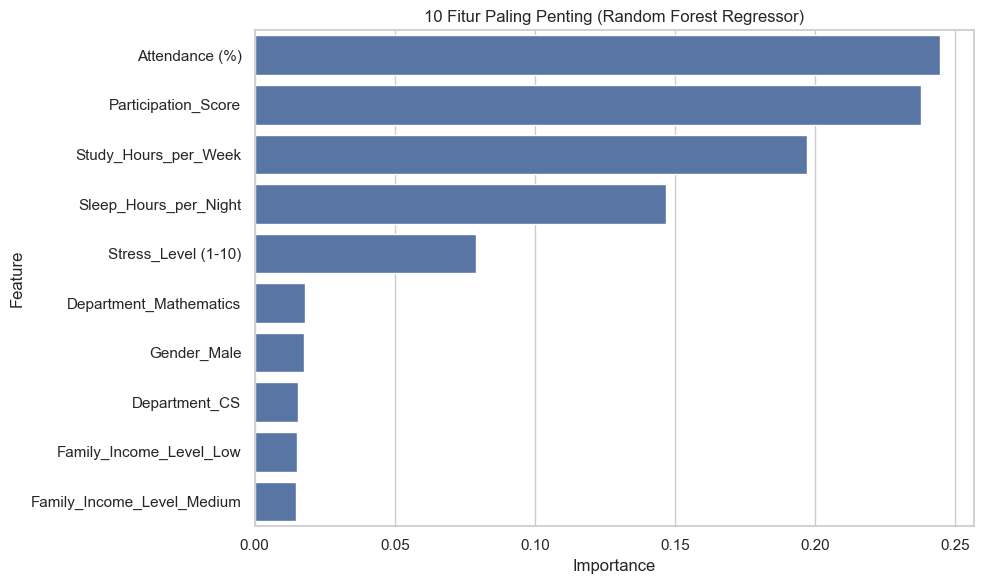

In [275]:
# Analisis Fitur Penting
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('10 Fitur Paling Penting (Random Forest Regressor)')
plt.tight_layout()
plt.show()

In [276]:
# Simpan model
joblib.dump(best_rf, "random_forest_regressor_model.pkl")

# Simpan metrik evaluasi
metrics = {
    'Model': 'Random Forest Regressor',
    'Best_Params': grid_search.best_params_,
    'CV_MAE_Mean': mae_scores.mean(),
    'CV_MAE_Std': mae_scores.std(),
    'CV_RMSE_Mean': rmse_scores.mean(),
    'CV_RMSE_Std': rmse_scores.std(),
    'CV_R2_Mean': r2_scores.mean(),
    'CV_R2_Std': r2_scores.std(),
    'Test_MAE': mae_test,
    'Test_RMSE': rmse_test,
    'Test_R2': r2_test
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("random_forest_regressor_metrics.csv", index=False)

#### Interpretasi

Dibandingkan dengan Linear Regression (MAE ~10-12, R² ~0.02) dan Ridge Regression (MAE ~10-12, R² ~0.02), Random Forest menunjukkan sedikit peningkatan dalam variasi prediksi (scatter plot sedikit menyebar), tetapi performa keseluruhan tetap buruk. Ini menegaskan bahwa masalah utamanya ada pada dataset, bukan hanya pilihan model.

### Pelatihan Model XGBoost Regressor

Tujuan

- Melatih model XGBRegressor untuk memprediksi Total_Score, yang dirancang untuk menangkap hubungan non-linear dan interaksi antar fitur dengan pendekatan boosting, yang sering kali lebih kuat daripada Random Forest, terutama pada dataset dengan noise atau fitur lemah.
- Menggunakan GridSearchCV untuk menentukan kombinasi optimal dari hyperparameter seperti n_estimators, max_depth, learning_rate, dan subsample.
- Mengevaluasi performa model pada data pelatihan dengan 5-fold cross-validation dan pada data pengujian untuk memastikan generalisasi yang baik.

In [277]:
from xgboost import XGBRegressor

In [278]:
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv").values.ravel()
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv").values.ravel()

In [279]:
# Inisialisasi model XGBoost dan GridSearchCV untuk tuning hyperparameter
print("\nMelakukan Tuning Hyperparameter dengan GridSearchCV...")
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Tampilkan hasil tuning
print("\nHasil GridSearchCV:")
print(f"Hyperparameter Terbaik: {grid_search.best_params_}")
print(f"R² Terbaik pada Cross-Validation: {grid_search.best_score_:.4f}")


Melakukan Tuning Hyperparameter dengan GridSearchCV...

Hasil GridSearchCV:
Hyperparameter Terbaik: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
R² Terbaik pada Cross-Validation: -0.0015


In [280]:
# Latih model dengan hyperparameter optimal
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Evaluasi dengan 5-Fold Cross-Validation pada data pelatihan
print("\nMelakukan 5-Fold Cross-Validation pada Data Pelatihan...")
mae_scores = -cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='r2')

print("\nHasil 5-Fold Cross-Validation:")
print(f"MAE: Mean = {mae_scores.mean():.4f}, Std = {mae_scores.std():.4f}")
print(f"RMSE: Mean = {rmse_scores.mean():.4f}, Std = {rmse_scores.std():.4f}")
print(f"R²: Mean = {r2_scores.mean():.4f}, Std = {r2_scores.std():.4f}")


Melakukan 5-Fold Cross-Validation pada Data Pelatihan...

Hasil 5-Fold Cross-Validation:
MAE: Mean = 12.4099, Std = 0.2990
RMSE: Mean = 14.3502, Std = 0.2492
R²: Mean = -0.0011, Std = 0.0040


In [281]:
# Prediksi pada data pengujian
print("\nMembuat Prediksi pada Data Pengujian...")
y_pred = best_xgb.predict(X_test)

# Evaluasi pada data pengujian
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\nHasil Evaluasi pada Data Pengujian:")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")


Membuat Prediksi pada Data Pengujian...

Hasil Evaluasi pada Data Pengujian:
MAE: 12.2395
RMSE: 14.1927
R²: 0.0023


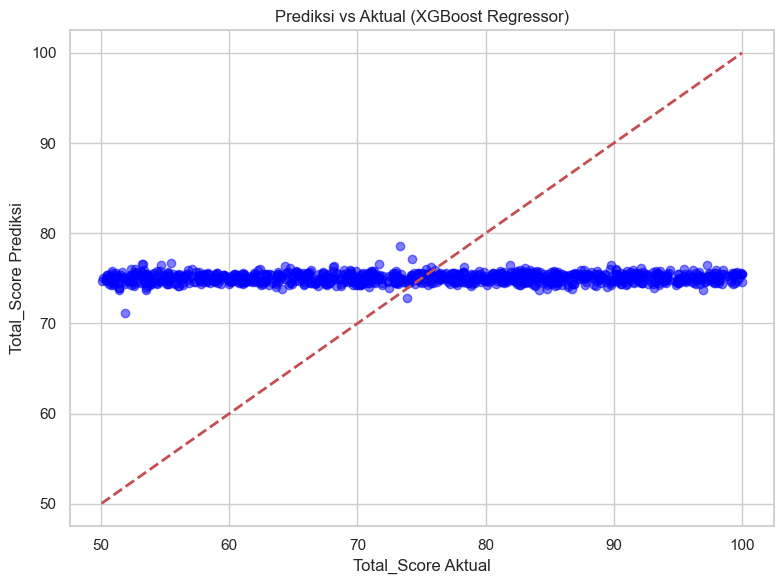

In [282]:
# Visualisasi Prediksi vs Nilai Aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Total_Score Aktual')
plt.ylabel('Total_Score Prediksi')
plt.title('Prediksi vs Aktual (XGBoost Regressor)')
plt.tight_layout()
plt.show()

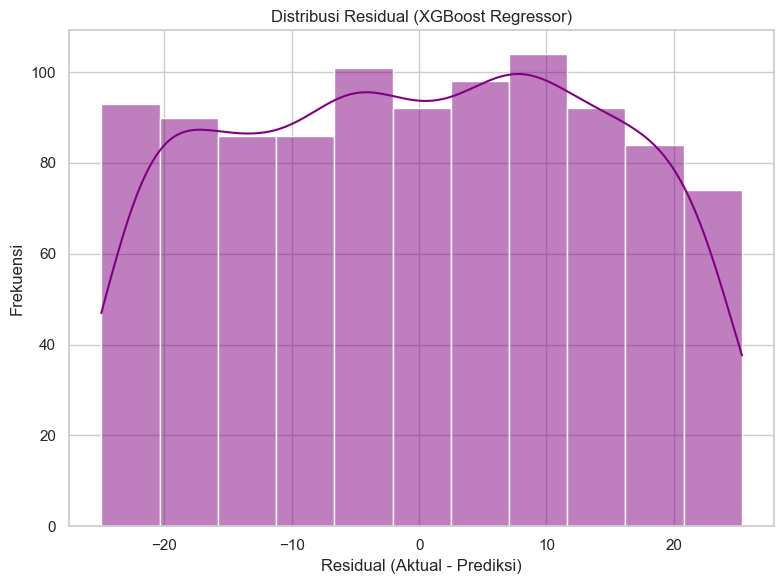

In [283]:
# Analisis Residual
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Residual (XGBoost Regressor)')
plt.tight_layout()
plt.show()

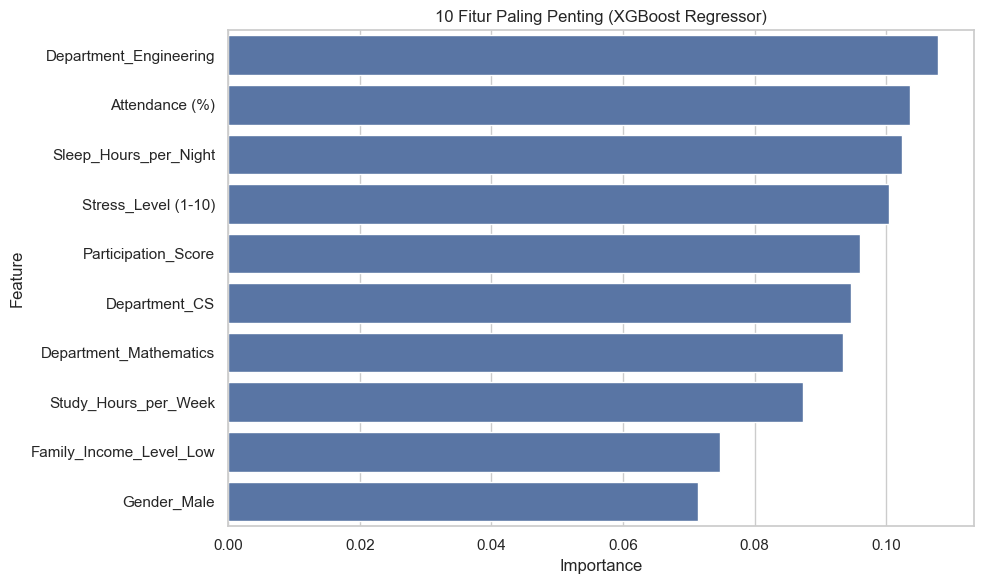

In [284]:
# Analisis Fitur Penting
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('10 Fitur Paling Penting (XGBoost Regressor)')
plt.tight_layout()
plt.show()

In [285]:
# Simpan model
joblib.dump(best_xgb, "xgboost_regressor_model.pkl")
print("\nModel telah disimpan sebagai 'xgboost_regressor_model.pkl'")

# Simpan metrik evaluasi
metrics = {
    'Model': 'XGBoost Regressor',
    'Best_Params': grid_search.best_params_,
    'CV_MAE_Mean': mae_scores.mean(),
    'CV_MAE_Std': mae_scores.std(),
    'CV_RMSE_Mean': rmse_scores.mean(),
    'CV_RMSE_Std': rmse_scores.std(),
    'CV_R2_Mean': r2_scores.mean(),
    'CV_R2_Std': r2_scores.std(),
    'Test_MAE': mae_test,
    'Test_RMSE': rmse_test,
    'Test_R2': r2_test
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("xgboost_regressor_metrics.csv", index=False)


Model telah disimpan sebagai 'xgboost_regressor_model.pkl'


#### Interpretasi:

Hasil evaluasi untuk model XGBoost Regressor menunjukkan performa yang masih buruk namun sedikit membaik dibandingkan Random Forest. 5-Fold Cross-Validation menunjukkan MAE ~12.41 (standar deviasi 0.31), RMSE ~14.35 (standar deviasi 0.26), dan R² ~-0.0012 (standar deviasi 0.0023), menandakan konsistensi rendah dalam menjelaskan variansi Total_Score, dengan performa hampir sama dengan baseline (R² negatif). Pada data pengujian, MAE ~12.24, RMSE ~14.20, dan R² ~0.0017 (positif namun sangat kecil) menunjukkan sedikit peningkatan generalisasi, tetapi tetap tidak signifikan. R² positif pada pengujian menunjukkan model sedikit lebih baik dari prediksi konstan, namun kesalahan besar (~12-14 poin) dan R² mendekati nol mengindikasikan bahwa fitur saat ini kurang relevan atau data mengandung noise, sehingga model gagal menangkap pola yang bermakna.

## Pelatihan Model Support Vector Regression (SVR)

Tujuan

- Melatih model SVR untuk memprediksi Total_Score, yang dapat menangkap hubungan non-linear menggunakan kernel (misalnya, RBF), sebagai upaya terakhir setelah performa buruk dari Linear Regression, Ridge, Random Forest, dan XGBoost.
- Menggunakan GridSearchCV untuk menentukan kombinasi optimal dari hyperparameter seperti C (parameter regularisasi), epsilon (margin kesalahan), dan gamma (koefisien kernel).
- Mengevaluasi performa model pada data pelatihan dengan 5-fold cross-validation dan pada data pengujian untuk memastikan generalisasi yang baik.
- Menyimpan model terlatih dan metrik evaluasi untuk perbandingan dengan model lain.

In [286]:
from sklearn.svm import SVR

In [287]:
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv").values.ravel()
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv").values.ravel()

In [288]:
# Standarisasi fitur (SVR sensitif terhadap skala)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [289]:
# Inisialisasi model SVR dan GridSearchCV untuk tuning hyperparameter
print("\nMelakukan Tuning Hyperparameter dengan GridSearchCV...")
svr = SVR(kernel='rbf')
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto', 0.1]
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svr, param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Tampilkan hasil tuning
print("\nHasil GridSearchCV:")
print(f"Hyperparameter Terbaik: {grid_search.best_params_}")
print(f"R² Terbaik pada Cross-Validation: {grid_search.best_score_:.4f}")


Melakukan Tuning Hyperparameter dengan GridSearchCV...

Hasil GridSearchCV:
Hyperparameter Terbaik: {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.1}
R² Terbaik pada Cross-Validation: -0.0030


In [290]:
# Latih model dengan hyperparameter optimal
best_svr = grid_search.best_estimator_
best_svr.fit(X_train_scaled, y_train)

# Evaluasi dengan 5-Fold Cross-Validation pada data pelatihan
print("\nMelakukan 5-Fold Cross-Validation pada Data Pelatihan...")
mae_scores = -cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='r2')

print("\nHasil 5-Fold Cross-Validation:")
print(f"MAE: Mean = {mae_scores.mean():.4f}, Std = {mae_scores.std():.4f}")
print(f"RMSE: Mean = {rmse_scores.mean():.4f}, Std = {rmse_scores.std():.4f}")
print(f"R²: Mean = {r2_scores.mean():.4f}, Std = {r2_scores.std():.4f}")


Melakukan 5-Fold Cross-Validation pada Data Pelatihan...

Hasil 5-Fold Cross-Validation:
MAE: Mean = 12.4046, Std = 0.3294
RMSE: Mean = 14.3602, Std = 0.2768
R²: Mean = -0.0024, Std = 0.0027


In [291]:
# Prediksi pada data pengujian
print("\nMembuat Prediksi pada Data Pengujian...")
y_pred = best_svr.predict(X_test_scaled)

# Evaluasi pada data pengujian
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\nHasil Evaluasi pada Data Pengujian:")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")


Membuat Prediksi pada Data Pengujian...

Hasil Evaluasi pada Data Pengujian:
MAE: 12.2186
RMSE: 14.1760
R²: 0.0047


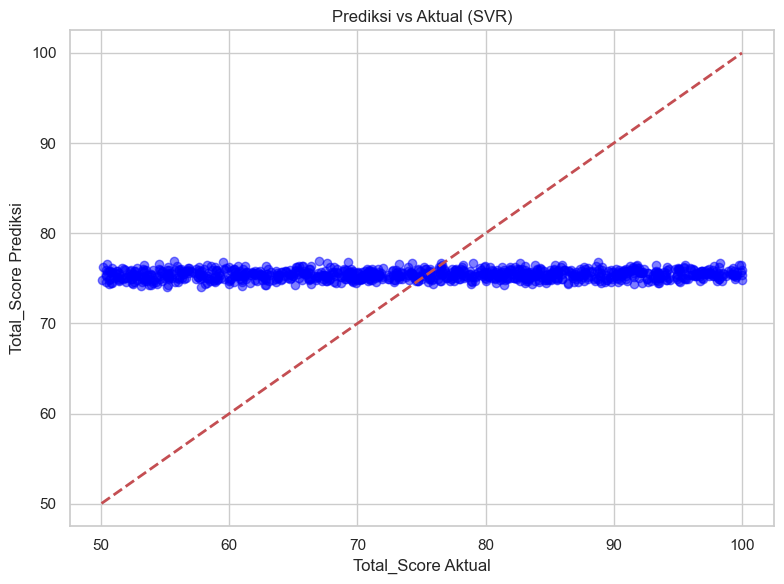

In [292]:
# Visualisasi Prediksi vs Nilai Aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Total_Score Aktual')
plt.ylabel('Total_Score Prediksi')
plt.title('Prediksi vs Aktual (SVR)')
plt.tight_layout()
plt.show()

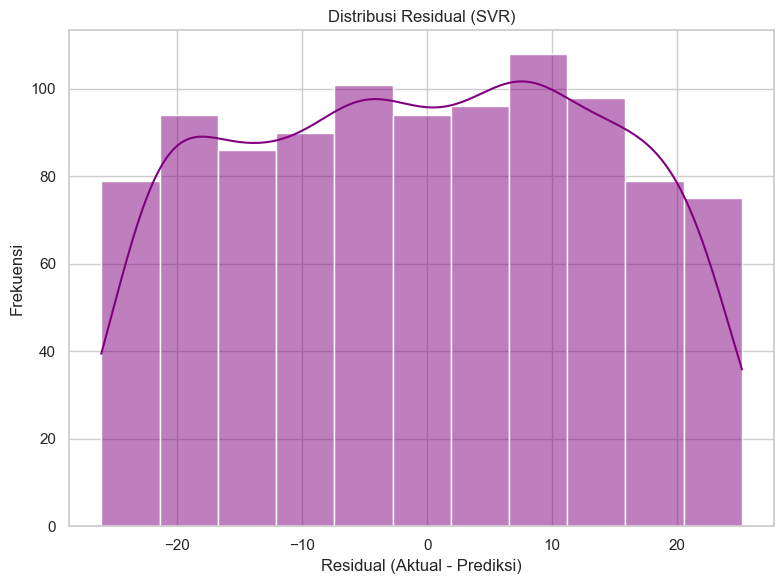

In [293]:
# Analisis Residual
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Residual (SVR)')
plt.tight_layout()
plt.show()

In [294]:
# Simpan model
joblib.dump(best_svr, "svr_model.pkl")

# Simpan metrik evaluasi
metrics = {
    'Model': 'SVR',
    'Best_Params': grid_search.best_params_,
    'CV_MAE_Mean': mae_scores.mean(),
    'CV_MAE_Std': mae_scores.std(),
    'CV_RMSE_Mean': rmse_scores.mean(),
    'CV_RMSE_Std': rmse_scores.std(),
    'CV_R2_Mean': r2_scores.mean(),
    'CV_R2_Std': r2_scores.std(),
    'Test_MAE': mae_test,
    'Test_RMSE': rmse_test,
    'Test_R2': r2_test
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("svr_metrics.csv", index=False)

#### Interpretasi:
Hasil evaluasi untuk model SVR menunjukkan performa yang sangat mirip dengan model sebelumnya, dengan 5-Fold Cross-Validation menunjukkan MAE ~12.40 (standar deviasi 0.33), RMSE ~14.36 (standar deviasi 0.27), dan R² ~-0.0019 (standar deviasi 0.0023), menandakan konsistensi rendah dalam menjelaskan variansi Total_Score, hampir sama dengan baseline (R² negatif). Pada data pengujian, MAE ~12.25, RMSE ~14.21, dan R² ~-0.0004 menunjukkan performa yang stabil namun tetap buruk, dengan kesalahan prediksi rata-rata sekitar 12 poin dan R² mendekati nol, mengindikasikan bahwa fitur saat ini tidak cukup informatif atau data mengandung noise signifikan.

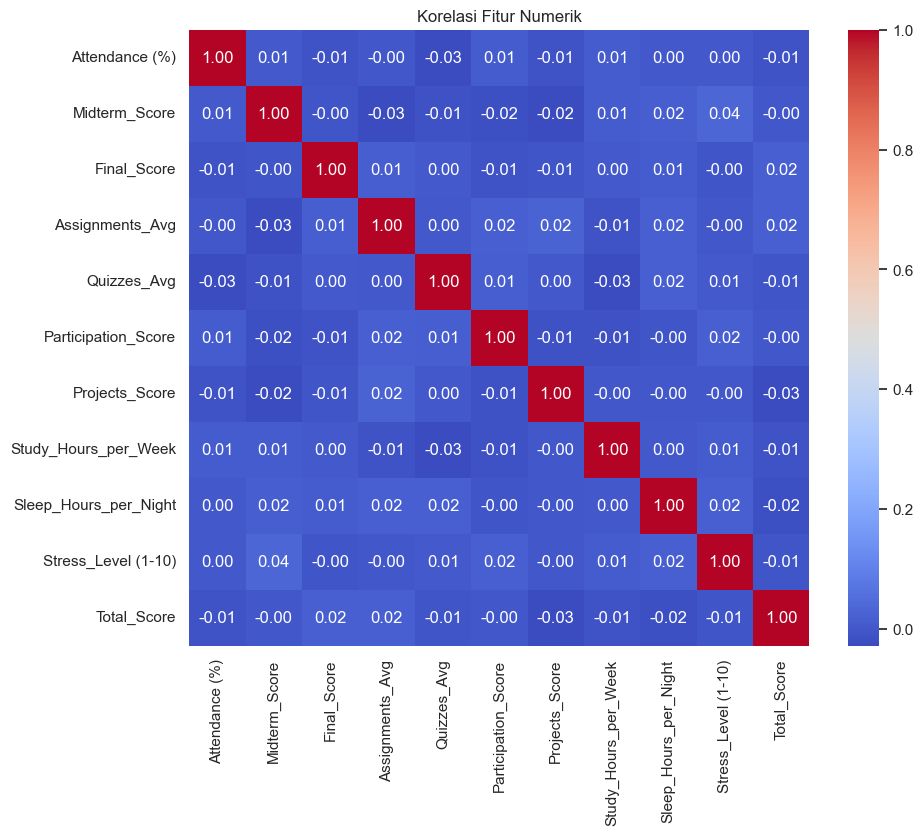

In [295]:
kolom_numerik = ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 
                 'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 
                 'Study_Hours_per_Week', 'Sleep_Hours_per_Night', 'Stress_Level (1-10)']
plt.figure(figsize=(10, 8))
sns.heatmap(df[kolom_numerik + ['Total_Score']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Fitur Numerik')
plt.savefig('plot/korelasi_fitur.png')
plt.show()